## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

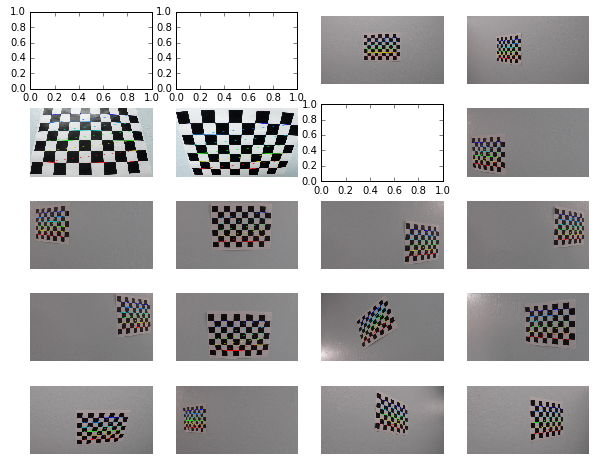

In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(10, 8))

# Step through the list and search for chessboard corners
for ax, fname in zip(axes.flat, images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        ax.axis('off')
        ax.imshow(img)

cv2.destroyAllWindows()

## Undirsorting images
Display the undistortion result on the examples of chessboard and real-world images and saving the undistortion parameters for future use:
* Camera Matrix
* Distortion coefficient

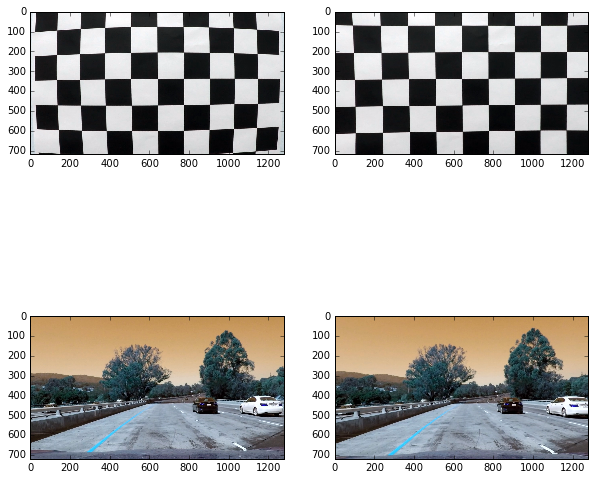

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

real_img = cv2.imread('./test_images/test1.jpg')
real_dst = cv2.undistort(real_img, mtx, dist, None, mtx)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [img, dst, real_img, real_dst]):
    ax.imshow(img)
    
pickle.dump(
    {
        'mtx': mtx,
        'dist': dist
    }, open('./calibration.p', 'wb')
)

## Transform perspective

In [41]:
def region_of_interest_coords(shape):
    width, height = shape[1], shape[0]
    
    vertical_mark = 0.63
    top, bottom, trapezoid_height = vertical_mark * height, height, (1 - vertical_mark) * height
    
    padding = 0.06
    bottom_left, bottom_right = padding * width, (1 - padding) * width
    
    trapezoid_ratio = 0.22
    trapezoid_length = bottom_right - bottom_left
    top_length = trapezoid_length * trapezoid_ratio
    trapezoid_offset = (trapezoid_length - top_length) / 2
    top_left, top_right = bottom_left + trapezoid_offset, bottom_right - trapezoid_offset
    
    trapezoid_coords = np.float32([
        [top_left, top], [top_right, top],
        [bottom_right, bottom], [bottom_left, bottom]
    ])
    
    return trapezoid_coords

In [42]:
def dst_coords(shape):
    width, height = shape[1], shape[0]
    offset = 0
    
    return np.float32([
        [offset, 0], [width - offset, 0],
        [width - offset, height], [offset, height] 
    ])

In [43]:
def draw_lines(img, coords):
    lines = zip(
        coords,
        np.insert(coords[:-1], 0, coords[-1], axis=0)
    )
        
    for x, y in lines:
        x = tuple(x)
        y = tuple(y)
        cv2.line(img, x, y, [255, 0, 0], 3)
        
    return img

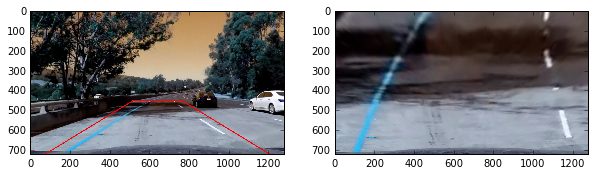

In [44]:
calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
mtx = calibration_parameters['mtx']
dist = calibration_parameters['dist']

lanes_image = cv2.imread('./test_images/test5.jpg')
undistorted = cv2.undistort(lanes_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

src = region_of_interest_coords(undistorted.shape)
dst = dst_coords(undistorted.shape)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(
    undistorted, M, 
    (undistorted.shape[1], undistorted.shape[0])
)

undistorted_lines = draw_lines(undistorted, src)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [undistorted_lines, warped]):
    ax.imshow(img)

##Color transformation

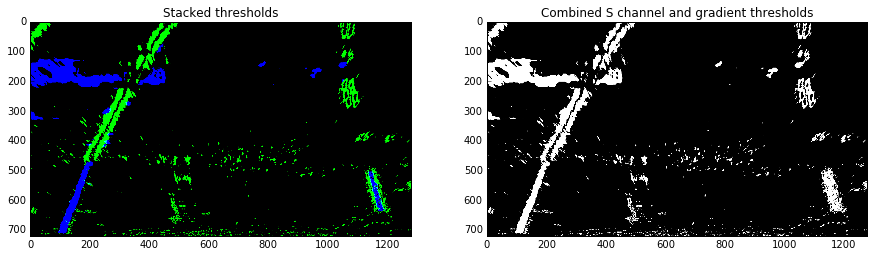

In [46]:
def color_transformation(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# color_binary, combined_binary = color_transformation_udacity( cv2.imread('./test_images/test5.jpg') )
color_binary, combined_binary = color_transformation( warped )

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

##Finding lanes

In [47]:
def polyfit(binary_warped, xm_per_pix=1, ym_per_pix=1):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    # left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    # right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

##Calculating curvature

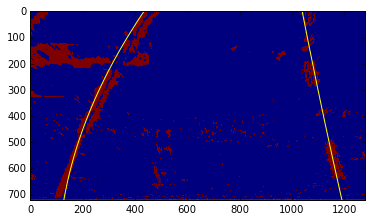

In [48]:
left_fit, right_fit = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)

# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(combined_binary)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [49]:
def curvature_radius(y_eval, left_fit, right_fit, xm_per_pix=1.0, ym_per_pix=1.0):
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

##Entire pipeline

Left curve radius: 2457 m
Right curve radius: 23920 m


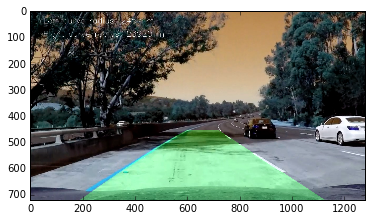

In [50]:
def lanes_detection(img):

    calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
    mtx = calibration_parameters['mtx']
    dist = calibration_parameters['dist']

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    src = region_of_interest_coords(undistorted.shape)
    dst = dst_coords(undistorted.shape)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective( undistorted, M, (undistorted.shape[1], undistorted.shape[0]) )

    color_binary, combined_binary = color_transformation(warped)

    left_fit, right_fit = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    res_image = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    y_eval = np.max(ploty)
    left_curverad, right_curverad = curvature_radius(y_eval, left_fit, right_fit, xm_per_pix=3.7/700, ym_per_pix=30/720)

    cv2.putText(res_image, 'Left curve radius: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    cv2.putText(res_image, 'Right curve radius: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    print('Left curve radius: {:.0f} m'.format(left_curverad))
    print('Right curve radius: {:.0f} m'.format(right_curverad))
    
    return res_image

res_image = lanes_detection(cv2.imread('./test_images/test5.jpg'))
plt.imshow(res_image)

##Video

In [51]:
from moviepy.editor import VideoFileClip
white_output = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lanes_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Left curve radius: 1693 m
Right curve radius: 2442 m
[MoviePy] >>>> Building video ./output_video.mp4


[MoviePy] Writing video ./output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:16,  9.23it/s]

Left curve radius: 1693 m
Right curve radius: 2442 m


  0%|          | 2/1261 [00:00<02:13,  9.41it/s]

Left curve radius: 1620 m
Right curve radius: 2988 m
Left curve radius: 1528 m
Right curve radius: 3286 m


  0%|          | 4/1261 [00:00<02:13,  9.42it/s]

  0%|          | 6/1261 [00:00<02:08,  9.73it/s]

Left curve radius: 1479 m
Right curve radius: 3363 m
Left curve radius: 1439 m
Right curve radius: 3541 m
Left curve radius: 1485 m
Right curve radius: 3546 m


  1%|          | 8/1261 [00:00<02:04, 10.04it/s]

Left curve radius: 1553 m
Right curve radius: 3400 m
Left curve radius: 1640 m
Right curve radius: 1560 m
Left curve radius: 1706 m
Right curve radius: 2035 m


  1%|          | 10/1261 [00:00<02:03, 10.12it/s]

  1%|          | 11/1261 [00:01<02:07,  9.79it/s]

Left curve radius: 1714 m
Right curve radius: 2358 m
Left curve radius: 1742 m
Right curve radius: 3153 m


  1%|          | 12/1261 [00:01<02:14,  9.31it/s]

  1%|          | 13/1261 [00:01<02:19,  8.96it/s]

Left curve radius: 1924 m
Right curve radius: 2331 m
Left curve radius: 2112 m
Right curve radius: 2305 m


  1%|          | 14/1261 [00:01<02:31,  8.26it/s]

  1%|          | 15/1261 [00:01<02:31,  8.25it/s]

Left curve radius: 2007 m
Right curve radius: 3374 m
Left curve radius: 2023 m
Right curve radius: 3409 m


  1%|▏         | 16/1261 [00:01<02:43,  7.61it/s]

  1%|▏         | 17/1261 [00:01<02:41,  7.68it/s]

Left curve radius: 2041 m
Right curve radius: 4002 m
Left curve radius: 1905 m
Right curve radius: 4211 m


  1%|▏         | 18/1261 [00:01<02:32,  8.14it/s]

  2%|▏         | 20/1261 [00:02<02:20,  8.82it/s]

Left curve radius: 1982 m
Right curve radius: 4068 m
Left curve radius: 2065 m
Right curve radius: 4436 m
Left curve radius: 2350 m
Right curve radius: 1645 m


  2%|▏         | 22/1261 [00:02<02:12,  9.33it/s]

Left curve radius: 2831 m
Right curve radius: 1648 m
Left curve radius: 2997 m
Right curve radius: 1597 m
Left curve radius: 3065 m
Right curve radius: 2161 m


  2%|▏         | 24/1261 [00:02<02:08,  9.59it/s]

  2%|▏         | 26/1261 [00:02<02:03,  9.97it/s]

Left curve radius: 2688 m
Right curve radius: 2491 m
Left curve radius: 2317 m
Right curve radius: 3106 m
Left curve radius: 2399 m
Right curve radius: 2571 m


  2%|▏         | 28/1261 [00:02<02:09,  9.53it/s]

Left curve radius: 2172 m
Right curve radius: 2797 m
Left curve radius: 2326 m
Right curve radius: 3040 m


  2%|▏         | 29/1261 [00:03<02:10,  9.47it/s]

  2%|▏         | 30/1261 [00:03<02:09,  9.50it/s]

Left curve radius: 2249 m
Right curve radius: 3328 m
Left curve radius: 1764 m
Right curve radius: 3133 m
Left curve radius: 1660 m
Right curve radius: 3456 m


  3%|▎         | 32/1261 [00:03<02:05,  9.79it/s]

Left curve radius: 1473 m
Right curve radius: 3287 m
Left curve radius: 1556 m
Right curve radius: 1925 m


  3%|▎         | 34/1261 [00:03<02:06,  9.69it/s]

  3%|▎         | 35/1261 [00:03<02:16,  8.96it/s]

Left curve radius: 1534 m
Right curve radius: 1635 m
Left curve radius: 1488 m
Right curve radius: 1928 m


  3%|▎         | 36/1261 [00:03<02:16,  8.99it/s]

  3%|▎         | 38/1261 [00:04<02:10,  9.39it/s]

Left curve radius: 1386 m
Right curve radius: 2781 m
Left curve radius: 1286 m
Right curve radius: 2382 m
Left curve radius: 1313 m
Right curve radius: 2212 m


  3%|▎         | 39/1261 [00:04<02:22,  8.57it/s]

  3%|▎         | 40/1261 [00:04<02:21,  8.60it/s]

Left curve radius: 1229 m
Right curve radius: 2628 m
Left curve radius: 1245 m
Right curve radius: 2945 m


  3%|▎         | 42/1261 [00:04<02:12,  9.19it/s]

Left curve radius: 1249 m
Right curve radius: 3175 m
Left curve radius: 1252 m
Right curve radius: 3273 m
Left curve radius: 1226 m
Right curve radius: 3293 m


  3%|▎         | 44/1261 [00:04<02:07,  9.55it/s]

  4%|▎         | 45/1261 [00:04<02:13,  9.11it/s]

Left curve radius: 1267 m
Right curve radius: 3354 m
Left curve radius: 1315 m
Right curve radius: 3303 m


  4%|▎         | 46/1261 [00:04<02:13,  9.13it/s]

  4%|▍         | 48/1261 [00:05<02:06,  9.56it/s]

Left curve radius: 1409 m
Right curve radius: 1568 m
Left curve radius: 1431 m
Right curve radius: 1935 m
Left curve radius: 1430 m
Right curve radius: 2465 m


  4%|▍         | 49/1261 [00:05<02:06,  9.59it/s]

  4%|▍         | 50/1261 [00:05<02:15,  8.95it/s]

Left curve radius: 1524 m
Right curve radius: 2425 m
Left curve radius: 1520 m
Right curve radius: 2157 m


  4%|▍         | 51/1261 [00:05<02:18,  8.74it/s]

  4%|▍         | 53/1261 [00:05<02:10,  9.23it/s]

Left curve radius: 1641 m
Right curve radius: 2328 m
Left curve radius: 1692 m
Right curve radius: 2666 m
Left curve radius: 1793 m
Right curve radius: 2904 m


  4%|▍         | 55/1261 [00:05<02:04,  9.68it/s]

Left curve radius: 1876 m
Right curve radius: 3267 m
Left curve radius: 1891 m
Right curve radius: 3484 m
Left curve radius: 2092 m
Right curve radius: 3342 m


  5%|▍         | 57/1261 [00:05<02:01,  9.92it/s]

Left curve radius: 2189 m
Right curve radius: 3631 m
Left curve radius: 2274 m
Right curve radius: 1718 m


  5%|▍         | 59/1261 [00:06<02:06,  9.53it/s]

  5%|▍         | 60/1261 [00:06<02:13,  9.01it/s]

Left curve radius: 2217 m
Right curve radius: 1692 m
Left curve radius: 2204 m
Right curve radius: 1806 m


  5%|▍         | 61/1261 [00:06<02:18,  8.68it/s]

  5%|▍         | 62/1261 [00:06<02:19,  8.61it/s]

Left curve radius: 2187 m
Right curve radius: 2246 m
Left curve radius: 2086 m
Right curve radius: 2348 m


  5%|▍         | 63/1261 [00:06<02:23,  8.34it/s]

  5%|▌         | 65/1261 [00:06<02:14,  8.87it/s]

Left curve radius: 2079 m
Right curve radius: 2467 m
Left curve radius: 1936 m
Right curve radius: 2771 m
Left curve radius: 1973 m
Right curve radius: 2944 m


  5%|▌         | 66/1261 [00:07<02:39,  7.48it/s]

  5%|▌         | 67/1261 [00:07<02:41,  7.40it/s]

Left curve radius: 1954 m
Right curve radius: 3623 m
Left curve radius: 1944 m
Right curve radius: 3361 m


  5%|▌         | 68/1261 [00:07<02:35,  7.68it/s]

  5%|▌         | 69/1261 [00:07<02:26,  8.12it/s]

Left curve radius: 1849 m
Right curve radius: 4074 m
Left curve radius: 1760 m
Right curve radius: 3915 m


  6%|▌         | 70/1261 [00:07<02:29,  7.97it/s]

  6%|▌         | 71/1261 [00:07<02:23,  8.31it/s]

Left curve radius: 1761 m
Right curve radius: 2123 m
Left curve radius: 2072 m
Right curve radius: 1570 m


  6%|▌         | 72/1261 [00:07<02:28,  8.01it/s]

  6%|▌         | 73/1261 [00:07<02:25,  8.16it/s]

Left curve radius: 2144 m
Right curve radius: 1594 m
Left curve radius: 2173 m
Right curve radius: 1722 m


  6%|▌         | 74/1261 [00:08<02:29,  7.96it/s]

  6%|▌         | 75/1261 [00:08<02:26,  8.11it/s]

Left curve radius: 2233 m
Right curve radius: 2112 m
Left curve radius: 2300 m
Right curve radius: 2309 m


  6%|▌         | 76/1261 [00:08<02:25,  8.16it/s]

  6%|▌         | 77/1261 [00:08<02:22,  8.32it/s]

Left curve radius: 2597 m
Right curve radius: 2395 m
Left curve radius: 2847 m
Right curve radius: 2494 m


  6%|▌         | 78/1261 [00:08<03:11,  6.19it/s]

  6%|▋         | 79/1261 [00:08<02:54,  6.76it/s]

Left curve radius: 3078 m
Right curve radius: 2689 m
Left curve radius: 3955 m
Right curve radius: 2923 m


  6%|▋         | 80/1261 [00:08<02:40,  7.36it/s]

  6%|▋         | 81/1261 [00:09<02:30,  7.83it/s]

Left curve radius: 3879 m
Right curve radius: 2935 m
Left curve radius: 3842 m
Right curve radius: 3228 m


  7%|▋         | 82/1261 [00:09<02:24,  8.17it/s]

  7%|▋         | 83/1261 [00:09<02:22,  8.27it/s]

Left curve radius: 3830 m
Right curve radius: 3231 m
Left curve radius: 3606 m
Right curve radius: 1683 m


  7%|▋         | 84/1261 [00:09<02:28,  7.95it/s]

  7%|▋         | 85/1261 [00:09<02:52,  6.82it/s]

Left curve radius: 4413 m
Right curve radius: 1890 m
Left curve radius: 4029 m
Right curve radius: 1578 m


  7%|▋         | 86/1261 [00:09<02:49,  6.94it/s]

  7%|▋         | 87/1261 [00:09<02:39,  7.38it/s]

Left curve radius: 3248 m
Right curve radius: 2009 m
Left curve radius: 2570 m
Right curve radius: 2544 m


  7%|▋         | 88/1261 [00:09<02:34,  7.60it/s]

  7%|▋         | 89/1261 [00:10<02:24,  8.09it/s]

Left curve radius: 2085 m
Right curve radius: 2346 m
Left curve radius: 1809 m
Right curve radius: 2731 m


  7%|▋         | 90/1261 [00:10<02:24,  8.10it/s]

  7%|▋         | 91/1261 [00:10<02:19,  8.39it/s]

Left curve radius: 1612 m
Right curve radius: 3054 m
Left curve radius: 1690 m
Right curve radius: 3232 m


  7%|▋         | 92/1261 [00:10<02:18,  8.42it/s]

  7%|▋         | 93/1261 [00:10<02:12,  8.80it/s]

Left curve radius: 1751 m
Right curve radius: 3443 m
Left curve radius: 1593 m
Right curve radius: 3591 m
Left curve radius: 1584 m
Right curve radius: 3672 m


  8%|▊         | 95/1261 [00:10<02:09,  9.03it/s]

  8%|▊         | 96/1261 [00:10<02:06,  9.24it/s]

Left curve radius: 1615 m
Right curve radius: 3578 m
Left curve radius: 1957 m
Right curve radius: 1592 m
Left curve radius: 1862 m
Right curve radius: 1598 m


  8%|▊         | 98/1261 [00:11<02:02,  9.47it/s]

  8%|▊         | 99/1261 [00:11<02:04,  9.37it/s]

Left curve radius: 1840 m
Right curve radius: 1897 m
Left curve radius: 1785 m
Right curve radius: 2337 m


  8%|▊         | 101/1261 [00:11<02:00,  9.65it/s]

Left curve radius: 1714 m
Right curve radius: 2700 m
Left curve radius: 1823 m
Right curve radius: 2236 m
Left curve radius: 1710 m
Right curve radius: 2677 m


  8%|▊         | 103/1261 [00:11<01:58,  9.76it/s]

  8%|▊         | 105/1261 [00:11<01:55,  9.98it/s]

Left curve radius: 1715 m
Right curve radius: 2816 m
Left curve radius: 1737 m
Right curve radius: 2895 m
Left curve radius: 1851 m
Right curve radius: 2935 m


  8%|▊         | 107/1261 [00:11<01:53, 10.18it/s]

Left curve radius: 1762 m
Right curve radius: 3222 m
Left curve radius: 1754 m
Right curve radius: 3221 m
Left curve radius: 1653 m
Right curve radius: 1838 m


  9%|▊         | 109/1261 [00:12<01:52, 10.26it/s]

  9%|▉         | 111/1261 [00:12<01:51, 10.33it/s]

Left curve radius: 1831 m
Right curve radius: 1487 m
Left curve radius: 1735 m
Right curve radius: 1576 m
Left curve radius: 1694 m
Right curve radius: 2004 m


  9%|▉         | 113/1261 [00:12<01:55,  9.94it/s]

Left curve radius: 1725 m
Right curve radius: 2245 m
Left curve radius: 1532 m
Right curve radius: 2896 m
Left curve radius: 1750 m
Right curve radius: 2349 m


  9%|▉         | 115/1261 [00:12<01:55,  9.96it/s]

  9%|▉         | 117/1261 [00:12<01:53, 10.05it/s]

Left curve radius: 1562 m
Right curve radius: 2610 m
Left curve radius: 1532 m
Right curve radius: 2815 m
Left curve radius: 1533 m
Right curve radius: 2875 m


  9%|▉         | 119/1261 [00:13<01:53, 10.08it/s]

Left curve radius: 1424 m
Right curve radius: 2952 m
Left curve radius: 1417 m
Right curve radius: 3006 m
Left curve radius: 1364 m
Right curve radius: 3011 m


 10%|▉         | 121/1261 [00:13<01:51, 10.26it/s]

Left curve radius: 1423 m
Right curve radius: 1747 m
Left curve radius: 1474 m
Right curve radius: 1676 m


 10%|▉         | 123/1261 [00:13<01:54,  9.98it/s]

 10%|▉         | 125/1261 [00:13<01:53, 10.00it/s]

Left curve radius: 1393 m
Right curve radius: 1801 m
Left curve radius: 1374 m
Right curve radius: 2117 m
Left curve radius: 1344 m
Right curve radius: 2325 m


 10%|█         | 127/1261 [00:13<01:53, 10.01it/s]

Left curve radius: 1488 m
Right curve radius: 2381 m
Left curve radius: 1445 m
Right curve radius: 2626 m
Left curve radius: 1474 m
Right curve radius: 2867 m


 10%|█         | 129/1261 [00:14<01:51, 10.11it/s]

 10%|█         | 131/1261 [00:14<01:50, 10.19it/s]

Left curve radius: 1426 m
Right curve radius: 3002 m
Left curve radius: 1419 m
Right curve radius: 3125 m
Left curve radius: 1453 m
Right curve radius: 3251 m


 11%|█         | 133/1261 [00:14<01:49, 10.29it/s]

Left curve radius: 1453 m
Right curve radius: 3203 m
Left curve radius: 1499 m
Right curve radius: 3032 m
Left curve radius: 1634 m
Right curve radius: 1728 m


 11%|█         | 135/1261 [00:14<01:53,  9.96it/s]

 11%|█         | 137/1261 [00:14<01:50, 10.13it/s]

Left curve radius: 1681 m
Right curve radius: 2144 m
Left curve radius: 1755 m
Right curve radius: 2083 m
Left curve radius: 1760 m
Right curve radius: 2551 m


 11%|█         | 139/1261 [00:15<01:54,  9.79it/s]

Left curve radius: 1792 m
Right curve radius: 2673 m
Left curve radius: 1907 m
Right curve radius: 2335 m


 11%|█         | 140/1261 [00:15<01:53,  9.84it/s]

 11%|█▏        | 142/1261 [00:15<01:51, 10.05it/s]

Left curve radius: 2009 m
Right curve radius: 2870 m
Left curve radius: 2193 m
Right curve radius: 3117 m
Left curve radius: 2314 m
Right curve radius: 3434 m


 11%|█▏        | 144/1261 [00:15<01:50, 10.14it/s]

Left curve radius: 2045 m
Right curve radius: 3129 m
Left curve radius: 2002 m
Right curve radius: 3725 m
Left curve radius: 2066 m
Right curve radius: 3731 m


 12%|█▏        | 146/1261 [00:15<01:48, 10.32it/s]

 12%|█▏        | 148/1261 [00:15<01:46, 10.41it/s]

Left curve radius: 2108 m
Right curve radius: 1521 m
Left curve radius: 2216 m
Right curve radius: 1605 m
Left curve radius: 2042 m
Right curve radius: 1904 m


 12%|█▏        | 150/1261 [00:16<01:45, 10.56it/s]

Left curve radius: 1942 m
Right curve radius: 2134 m
Left curve radius: 2030 m
Right curve radius: 2362 m
Left curve radius: 2204 m
Right curve radius: 2154 m


 12%|█▏        | 152/1261 [00:16<01:45, 10.56it/s]

 12%|█▏        | 154/1261 [00:16<01:44, 10.57it/s]

Left curve radius: 2267 m
Right curve radius: 2300 m
Left curve radius: 2023 m
Right curve radius: 3052 m
Left curve radius: 2180 m
Right curve radius: 3206 m


 12%|█▏        | 156/1261 [00:16<01:45, 10.48it/s]

Left curve radius: 2127 m
Right curve radius: 3460 m
Left curve radius: 2113 m
Right curve radius: 3513 m
Left curve radius: 2037 m
Right curve radius: 3532 m


 13%|█▎        | 158/1261 [00:16<01:45, 10.47it/s]

Left curve radius: 1906 m
Right curve radius: 3284 m
Left curve radius: 2052 m
Right curve radius: 1607 m


 13%|█▎        | 160/1261 [00:17<01:48, 10.12it/s]

 13%|█▎        | 162/1261 [00:17<01:46, 10.32it/s]

Left curve radius: 1812 m
Right curve radius: 1967 m
Left curve radius: 1858 m
Right curve radius: 1813 m
Left curve radius: 1774 m
Right curve radius: 2665 m


 13%|█▎        | 164/1261 [00:17<01:51,  9.83it/s]

 13%|█▎        | 165/1261 [00:17<01:52,  9.78it/s]

Left curve radius: 1686 m
Right curve radius: 2867 m
Left curve radius: 1707 m
Right curve radius: 2478 m
Left curve radius: 1800 m
Right curve radius: 2743 m


 13%|█▎        | 166/1261 [00:17<01:51,  9.83it/s]

 13%|█▎        | 168/1261 [00:17<01:48, 10.04it/s]

Left curve radius: 1789 m
Right curve radius: 3235 m
Left curve radius: 1669 m
Right curve radius: 3444 m
Left curve radius: 1786 m
Right curve radius: 3626 m


 13%|█▎        | 170/1261 [00:18<01:46, 10.25it/s]

Left curve radius: 1798 m
Right curve radius: 3642 m
Left curve radius: 1925 m
Right curve radius: 3327 m
Left curve radius: 2030 m
Right curve radius: 1679 m


 14%|█▎        | 172/1261 [00:18<01:45, 10.30it/s]

 14%|█▍        | 174/1261 [00:18<01:43, 10.47it/s]

Left curve radius: 1949 m
Right curve radius: 1892 m
Left curve radius: 1940 m
Right curve radius: 1939 m
Left curve radius: 1865 m
Right curve radius: 2072 m


 14%|█▍        | 176/1261 [00:18<01:44, 10.40it/s]

Left curve radius: 1729 m
Right curve radius: 2092 m
Left curve radius: 1710 m
Right curve radius: 2161 m
Left curve radius: 1780 m
Right curve radius: 2265 m


 14%|█▍        | 178/1261 [00:18<01:43, 10.42it/s]

 14%|█▍        | 180/1261 [00:19<01:43, 10.43it/s]

Left curve radius: 1950 m
Right curve radius: 2389 m
Left curve radius: 2023 m
Right curve radius: 2510 m
Left curve radius: 1900 m
Right curve radius: 2632 m


 14%|█▍        | 182/1261 [00:19<01:42, 10.48it/s]

Left curve radius: 1704 m
Right curve radius: 2743 m
Left curve radius: 1733 m
Right curve radius: 2764 m
Left curve radius: 1595 m
Right curve radius: 1932 m


 15%|█▍        | 184/1261 [00:19<01:43, 10.45it/s]

 15%|█▍        | 186/1261 [00:19<01:43, 10.41it/s]

Left curve radius: 1501 m
Right curve radius: 1995 m
Left curve radius: 1340 m
Right curve radius: 2111 m
Left curve radius: 1159 m
Right curve radius: 2317 m


 15%|█▍        | 188/1261 [00:19<01:42, 10.44it/s]

Left curve radius: 1128 m
Right curve radius: 2384 m
Left curve radius: 1148 m
Right curve radius: 2522 m
Left curve radius: 1155 m
Right curve radius: 2620 m


 15%|█▌        | 190/1261 [00:20<01:42, 10.42it/s]

Left curve radius: 1149 m
Right curve radius: 2749 m
Left curve radius: 1180 m
Right curve radius: 3184 m
Left curve radius: 1183 m
Right curve radius: 3436 m


 15%|█▌        | 192/1261 [00:20<01:44, 10.23it/s]

 15%|█▌        | 194/1261 [00:20<01:43, 10.32it/s]

Left curve radius: 1215 m
Right curve radius: 3357 m
Left curve radius: 1272 m
Right curve radius: 3403 m
Left curve radius: 1316 m
Right curve radius: 1964 m


 16%|█▌        | 196/1261 [00:20<01:42, 10.40it/s]

 16%|█▌        | 198/1261 [00:20<01:40, 10.53it/s]

Left curve radius: 1541 m
Right curve radius: 1757 m
Left curve radius: 1687 m
Right curve radius: 1765 m
Left curve radius: 1800 m
Right curve radius: 2231 m


 16%|█▌        | 200/1261 [00:20<01:41, 10.41it/s]

Left curve radius: 2028 m
Right curve radius: 1915 m
Left curve radius: 1879 m
Right curve radius: 2271 m
Left curve radius: 2070 m
Right curve radius: 2102 m


 16%|█▌        | 202/1261 [00:21<01:40, 10.49it/s]

 16%|█▌        | 204/1261 [00:21<01:41, 10.46it/s]

Left curve radius: 2007 m
Right curve radius: 2814 m
Left curve radius: 1838 m
Right curve radius: 2985 m
Left curve radius: 1721 m
Right curve radius: 3244 m


 16%|█▋        | 206/1261 [00:21<01:39, 10.58it/s]

Left curve radius: 1693 m
Right curve radius: 2987 m
Left curve radius: 1663 m
Right curve radius: 3178 m
Left curve radius: 1515 m
Right curve radius: 3165 m


 16%|█▋        | 208/1261 [00:21<01:41, 10.42it/s]

 17%|█▋        | 210/1261 [00:21<01:39, 10.54it/s]

Left curve radius: 1565 m
Right curve radius: 1744 m
Left curve radius: 1591 m
Right curve radius: 1976 m
Left curve radius: 1604 m
Right curve radius: 2039 m


 17%|█▋        | 212/1261 [00:22<01:39, 10.53it/s]

Left curve radius: 1636 m
Right curve radius: 2073 m
Left curve radius: 1531 m
Right curve radius: 2247 m
Left curve radius: 1496 m
Right curve radius: 2164 m


 17%|█▋        | 214/1261 [00:22<01:39, 10.55it/s]

Left curve radius: 1490 m
Right curve radius: 2682 m
Left curve radius: 1502 m
Right curve radius: 2961 m


 17%|█▋        | 216/1261 [00:22<01:42, 10.21it/s]

 17%|█▋        | 218/1261 [00:22<01:41, 10.30it/s]

Left curve radius: 1436 m
Right curve radius: 3362 m
Left curve radius: 1369 m
Right curve radius: 3071 m
Left curve radius: 1400 m
Right curve radius: 3645 m


 17%|█▋        | 220/1261 [00:22<01:46,  9.75it/s]

Left curve radius: 1370 m
Right curve radius: 3425 m
Left curve radius: 1494 m
Right curve radius: 1609 m
Left curve radius: 1596 m
Right curve radius: 1787 m


 18%|█▊        | 222/1261 [00:23<01:45,  9.89it/s]

 18%|█▊        | 223/1261 [00:23<01:46,  9.76it/s]

Left curve radius: 1621 m
Right curve radius: 1880 m
Left curve radius: 1687 m
Right curve radius: 2371 m


 18%|█▊        | 224/1261 [00:23<01:52,  9.24it/s]

 18%|█▊        | 226/1261 [00:23<01:48,  9.52it/s]

Left curve radius: 1614 m
Right curve radius: 2264 m
Left curve radius: 1803 m
Right curve radius: 2449 m
Left curve radius: 1868 m
Right curve radius: 2653 m


 18%|█▊        | 227/1261 [00:23<02:00,  8.56it/s]

 18%|█▊        | 228/1261 [00:23<02:01,  8.52it/s]

Left curve radius: 1958 m
Right curve radius: 2746 m
Left curve radius: 2094 m
Right curve radius: 3350 m


 18%|█▊        | 229/1261 [00:23<02:04,  8.27it/s]

 18%|█▊        | 230/1261 [00:24<02:02,  8.44it/s]

Left curve radius: 1865 m
Right curve radius: 3250 m
Left curve radius: 2002 m
Right curve radius: 3593 m


 18%|█▊        | 231/1261 [00:24<01:58,  8.69it/s]

 18%|█▊        | 232/1261 [00:24<01:57,  8.77it/s]

Left curve radius: 2043 m
Right curve radius: 3507 m
Left curve radius: 2122 m
Right curve radius: 3461 m


 19%|█▊        | 234/1261 [00:24<01:50,  9.25it/s]

 19%|█▊        | 235/1261 [00:24<01:48,  9.42it/s]

Left curve radius: 2269 m
Right curve radius: 1555 m
Left curve radius: 2236 m
Right curve radius: 1943 m
Left curve radius: 2268 m
Right curve radius: 2100 m


 19%|█▊        | 236/1261 [00:24<01:55,  8.89it/s]

 19%|█▉        | 237/1261 [00:24<01:55,  8.87it/s]

Left curve radius: 2005 m
Right curve radius: 2212 m
Left curve radius: 2053 m
Right curve radius: 1971 m


 19%|█▉        | 238/1261 [00:24<01:58,  8.63it/s]

 19%|█▉        | 239/1261 [00:25<01:56,  8.76it/s]

Left curve radius: 1941 m
Right curve radius: 2307 m
Left curve radius: 1885 m
Right curve radius: 2583 m


 19%|█▉        | 240/1261 [00:25<01:56,  8.75it/s]

 19%|█▉        | 241/1261 [00:25<01:58,  8.62it/s]

Left curve radius: 1929 m
Right curve radius: 2757 m
Left curve radius: 1834 m
Right curve radius: 2854 m


 19%|█▉        | 242/1261 [00:25<01:55,  8.82it/s]

 19%|█▉        | 243/1261 [00:25<02:01,  8.36it/s]

Left curve radius: 1928 m
Right curve radius: 2938 m
Left curve radius: 1826 m
Right curve radius: 3090 m


 19%|█▉        | 244/1261 [00:25<01:58,  8.58it/s]

 19%|█▉        | 245/1261 [00:25<02:01,  8.39it/s]

Left curve radius: 1778 m
Right curve radius: 3019 m
Left curve radius: 1804 m
Right curve radius: 1793 m


 20%|█▉        | 246/1261 [00:25<02:02,  8.32it/s]

 20%|█▉        | 247/1261 [00:25<01:59,  8.50it/s]

Left curve radius: 1707 m
Right curve radius: 1937 m
Left curve radius: 1704 m
Right curve radius: 2102 m
Left curve radius: 1583 m
Right curve radius: 2113 m


 20%|█▉        | 249/1261 [00:26<01:54,  8.86it/s]

 20%|█▉        | 250/1261 [00:26<02:08,  7.87it/s]

Left curve radius: 1657 m
Right curve radius: 2011 m
Left curve radius: 1610 m
Right curve radius: 2145 m


 20%|█▉        | 251/1261 [00:26<02:06,  7.98it/s]

 20%|█▉        | 252/1261 [00:26<02:01,  8.28it/s]

Left curve radius: 1727 m
Right curve radius: 2308 m
Left curve radius: 1803 m
Right curve radius: 2574 m


 20%|██        | 253/1261 [00:26<02:40,  6.29it/s]

 20%|██        | 254/1261 [00:26<02:37,  6.38it/s]

Left curve radius: 1714 m
Right curve radius: 2800 m
Left curve radius: 1828 m
Right curve radius: 3014 m


 20%|██        | 255/1261 [00:27<02:26,  6.86it/s]

 20%|██        | 256/1261 [00:27<02:12,  7.56it/s]

Left curve radius: 1790 m
Right curve radius: 3080 m
Left curve radius: 1799 m
Right curve radius: 3017 m
Left curve radius: 1856 m
Right curve radius: 1896 m


 20%|██        | 258/1261 [00:27<02:04,  8.06it/s]

 21%|██        | 259/1261 [00:27<02:00,  8.34it/s]

Left curve radius: 1857 m
Right curve radius: 1959 m
Left curve radius: 1821 m
Right curve radius: 1991 m


 21%|██        | 260/1261 [00:27<01:54,  8.75it/s]

 21%|██        | 262/1261 [00:27<01:48,  9.20it/s]

Left curve radius: 1746 m
Right curve radius: 2024 m
Left curve radius: 1913 m
Right curve radius: 2054 m
Left curve radius: 1995 m
Right curve radius: 2044 m


 21%|██        | 263/1261 [00:27<01:46,  9.36it/s]

 21%|██        | 265/1261 [00:28<01:41,  9.77it/s]

Left curve radius: 2256 m
Right curve radius: 2252 m
Left curve radius: 2366 m
Right curve radius: 2633 m
Left curve radius: 2222 m
Right curve radius: 2839 m


 21%|██        | 267/1261 [00:28<01:39,  9.98it/s]

Left curve radius: 2141 m
Right curve radius: 2948 m
Left curve radius: 2021 m
Right curve radius: 3016 m
Left curve radius: 1985 m
Right curve radius: 3027 m


 21%|██▏       | 269/1261 [00:28<01:37, 10.13it/s]

 21%|██▏       | 271/1261 [00:28<01:36, 10.30it/s]

Left curve radius: 2027 m
Right curve radius: 1753 m
Left curve radius: 2094 m
Right curve radius: 1699 m
Left curve radius: 2031 m
Right curve radius: 1802 m


 22%|██▏       | 273/1261 [00:28<01:34, 10.50it/s]

Left curve radius: 1855 m
Right curve radius: 2129 m
Left curve radius: 1813 m
Right curve radius: 2238 m
Left curve radius: 1871 m
Right curve radius: 2396 m


 22%|██▏       | 275/1261 [00:29<01:33, 10.58it/s]

 22%|██▏       | 277/1261 [00:29<01:32, 10.68it/s]

Left curve radius: 2199 m
Right curve radius: 2304 m
Left curve radius: 2292 m
Right curve radius: 2751 m
Left curve radius: 2227 m
Right curve radius: 3094 m


 22%|██▏       | 279/1261 [00:29<01:31, 10.79it/s]

Left curve radius: 2371 m
Right curve radius: 3380 m
Left curve radius: 2468 m
Right curve radius: 3359 m
Left curve radius: 2279 m
Right curve radius: 3281 m


 22%|██▏       | 281/1261 [00:29<01:30, 10.83it/s]

 22%|██▏       | 283/1261 [00:29<01:30, 10.81it/s]

Left curve radius: 2796 m
Right curve radius: 1675 m
Left curve radius: 2828 m
Right curve radius: 1832 m
Left curve radius: 2751 m
Right curve radius: 2030 m


 23%|██▎       | 285/1261 [00:29<01:29, 10.85it/s]

Left curve radius: 2868 m
Right curve radius: 2146 m
Left curve radius: 2661 m
Right curve radius: 2357 m
Left curve radius: 3474 m
Right curve radius: 2080 m


 23%|██▎       | 287/1261 [00:30<01:30, 10.77it/s]

 23%|██▎       | 289/1261 [00:30<01:30, 10.80it/s]

Left curve radius: 4203 m
Right curve radius: 2389 m
Left curve radius: 4070 m
Right curve radius: 2849 m
Left curve radius: 3413 m
Right curve radius: 3406 m


 23%|██▎       | 291/1261 [00:30<01:29, 10.85it/s]

Left curve radius: 3799 m
Right curve radius: 3612 m
Left curve radius: 3776 m
Right curve radius: 3683 m
Left curve radius: 3641 m
Right curve radius: 3575 m


 23%|██▎       | 293/1261 [00:30<01:29, 10.79it/s]

 23%|██▎       | 295/1261 [00:30<01:29, 10.84it/s]

Left curve radius: 5066 m
Right curve radius: 1590 m
Left curve radius: 4599 m
Right curve radius: 1882 m
Left curve radius: 4521 m
Right curve radius: 1912 m


 24%|██▎       | 297/1261 [00:31<01:28, 10.85it/s]

Left curve radius: 4236 m
Right curve radius: 2254 m
Left curve radius: 4036 m
Right curve radius: 2725 m
Left curve radius: 5748 m
Right curve radius: 2222 m


 24%|██▎       | 299/1261 [00:31<01:29, 10.78it/s]

 24%|██▍       | 301/1261 [00:31<01:28, 10.79it/s]

Left curve radius: 6921 m
Right curve radius: 2647 m
Left curve radius: 6054 m
Right curve radius: 3614 m
Left curve radius: 6000 m
Right curve radius: 4539 m


 24%|██▍       | 303/1261 [00:31<01:29, 10.67it/s]

Left curve radius: 6521 m
Right curve radius: 4573 m
Left curve radius: 6291 m
Right curve radius: 4911 m
Left curve radius: 6637 m
Right curve radius: 4684 m


 24%|██▍       | 305/1261 [00:31<01:29, 10.66it/s]

 24%|██▍       | 307/1261 [00:31<01:29, 10.66it/s]

Left curve radius: 11181 m
Right curve radius: 1677 m
Left curve radius: 13339 m
Right curve radius: 1717 m
Left curve radius: 7830 m
Right curve radius: 2661 m


 25%|██▍       | 309/1261 [00:32<01:27, 10.83it/s]

Left curve radius: 7376 m
Right curve radius: 3428 m
Left curve radius: 6962 m
Right curve radius: 3671 m
Left curve radius: 16521 m
Right curve radius: 2732 m


 25%|██▍       | 311/1261 [00:32<01:27, 10.81it/s]

 25%|██▍       | 313/1261 [00:32<01:27, 10.83it/s]

Left curve radius: 45060 m
Right curve radius: 3671 m
Left curve radius: 33898 m
Right curve radius: 6797 m
Left curve radius: 18386 m
Right curve radius: 7450 m


 25%|██▍       | 315/1261 [00:32<01:27, 10.83it/s]

Left curve radius: 43785 m
Right curve radius: 8457 m
Left curve radius: 28698 m
Right curve radius: 8943 m
Left curve radius: 77877 m
Right curve radius: 8304 m


 25%|██▌       | 317/1261 [00:32<01:27, 10.84it/s]

 25%|██▌       | 319/1261 [00:33<01:27, 10.77it/s]

Left curve radius: 13572 m
Right curve radius: 1667 m
Left curve radius: 10522 m
Right curve radius: 2004 m
Left curve radius: 16982 m
Right curve radius: 2390 m


 25%|██▌       | 321/1261 [00:33<01:27, 10.69it/s]

Left curve radius: 13090 m
Right curve radius: 2476 m
Left curve radius: 21547 m
Right curve radius: 3029 m
Left curve radius: 10355 m
Right curve radius: 2360 m


 26%|██▌       | 323/1261 [00:33<01:28, 10.55it/s]

 26%|██▌       | 325/1261 [00:33<01:28, 10.62it/s]

Left curve radius: 8340 m
Right curve radius: 2954 m
Left curve radius: 9209 m
Right curve radius: 3854 m
Left curve radius: 9875 m
Right curve radius: 5718 m


 26%|██▌       | 327/1261 [00:33<01:28, 10.60it/s]

Left curve radius: 10438 m
Right curve radius: 5902 m
Left curve radius: 11305 m
Right curve radius: 5908 m
Left curve radius: 10455 m
Right curve radius: 5898 m


 26%|██▌       | 329/1261 [00:34<01:27, 10.60it/s]

 26%|██▌       | 331/1261 [00:34<01:28, 10.53it/s]

Left curve radius: 6818 m
Right curve radius: 1764 m
Left curve radius: 7108 m
Right curve radius: 1738 m
Left curve radius: 17715 m
Right curve radius: 2694 m


 26%|██▋       | 333/1261 [00:34<01:27, 10.62it/s]

Left curve radius: 13051 m
Right curve radius: 2913 m
Left curve radius: 24914 m
Right curve radius: 3493 m
Left curve radius: 11447 m
Right curve radius: 2276 m


 27%|██▋       | 335/1261 [00:34<01:27, 10.64it/s]

 27%|██▋       | 337/1261 [00:34<01:26, 10.68it/s]

Left curve radius: 9810 m
Right curve radius: 3398 m
Left curve radius: 14849 m
Right curve radius: 7201 m
Left curve radius: 18795 m
Right curve radius: 15070 m


 27%|██▋       | 339/1261 [00:34<01:26, 10.65it/s]

Left curve radius: 19470 m
Right curve radius: 13565 m
Left curve radius: 21643 m
Right curve radius: 15423 m
Left curve radius: 13680 m
Right curve radius: 12665 m


 27%|██▋       | 341/1261 [00:35<01:25, 10.77it/s]

 27%|██▋       | 343/1261 [00:35<01:25, 10.75it/s]

Left curve radius: 19974 m
Right curve radius: 1973 m
Left curve radius: 9803 m
Right curve radius: 1720 m
Left curve radius: 9161 m
Right curve radius: 2230 m


 27%|██▋       | 345/1261 [00:35<01:24, 10.85it/s]

Left curve radius: 12017 m
Right curve radius: 2706 m
Left curve radius: 15249 m
Right curve radius: 4889 m
Left curve radius: 10743 m
Right curve radius: 3243 m


 28%|██▊       | 347/1261 [00:35<01:24, 10.84it/s]

 28%|██▊       | 349/1261 [00:35<01:23, 10.93it/s]

Left curve radius: 14851 m
Right curve radius: 4172 m
Left curve radius: 12131 m
Right curve radius: 13216 m
Left curve radius: 14718 m
Right curve radius: 21529 m


 28%|██▊       | 351/1261 [00:36<01:24, 10.80it/s]

Left curve radius: 16196 m
Right curve radius: 19885 m
Left curve radius: 17985 m
Right curve radius: 15292 m
Left curve radius: 27855 m
Right curve radius: 11454 m


 28%|██▊       | 353/1261 [00:36<01:24, 10.77it/s]

 28%|██▊       | 355/1261 [00:36<01:24, 10.74it/s]

Left curve radius: 115703 m
Right curve radius: 1871 m
Left curve radius: 19211 m
Right curve radius: 2120 m
Left curve radius: 17636 m
Right curve radius: 3290 m


 28%|██▊       | 357/1261 [00:36<01:24, 10.75it/s]

Left curve radius: 47275 m
Right curve radius: 3161 m
Left curve radius: 11074 m
Right curve radius: 3855 m
Left curve radius: 21742 m
Right curve radius: 3025 m


 28%|██▊       | 359/1261 [00:36<01:23, 10.78it/s]

 29%|██▊       | 361/1261 [00:37<01:22, 10.89it/s]

Left curve radius: 21368 m
Right curve radius: 6115 m
Left curve radius: 25251 m
Right curve radius: 8862 m
Left curve radius: 31556 m
Right curve radius: 9553 m


 29%|██▉       | 363/1261 [00:37<01:22, 10.93it/s]

Left curve radius: 15947 m
Right curve radius: 8662 m
Left curve radius: 12818 m
Right curve radius: 9015 m
Left curve radius: 7541 m
Right curve radius: 9762 m


 29%|██▉       | 365/1261 [00:37<01:22, 10.92it/s]

 29%|██▉       | 367/1261 [00:37<01:22, 10.81it/s]

Left curve radius: 4391 m
Right curve radius: 1508 m
Left curve radius: 3583 m
Right curve radius: 1599 m
Left curve radius: 3886 m
Right curve radius: 2761 m


 29%|██▉       | 369/1261 [00:37<01:22, 10.77it/s]

Left curve radius: 3281 m
Right curve radius: 2728 m
Left curve radius: 3539 m
Right curve radius: 5598 m
Left curve radius: 3534 m
Right curve radius: 6065 m


 29%|██▉       | 371/1261 [00:37<01:23, 10.69it/s]

 30%|██▉       | 373/1261 [00:38<01:23, 10.67it/s]

Left curve radius: 3255 m
Right curve radius: 6543 m
Left curve radius: 3281 m
Right curve radius: 17507 m
Left curve radius: 3267 m
Right curve radius: 35470 m


 30%|██▉       | 375/1261 [00:38<01:23, 10.58it/s]

Left curve radius: 3951 m
Right curve radius: 106454 m
Left curve radius: 4623 m
Right curve radius: 28648 m
Left curve radius: 6846 m
Right curve radius: 30708 m


 30%|██▉       | 377/1261 [00:38<01:23, 10.65it/s]

 30%|███       | 379/1261 [00:38<01:23, 10.55it/s]

Left curve radius: 7783 m
Right curve radius: 1418 m
Left curve radius: 6831 m
Right curve radius: 1522 m
Left curve radius: 14975 m
Right curve radius: 2040 m


 30%|███       | 381/1261 [00:38<01:22, 10.62it/s]

Left curve radius: 24559 m
Right curve radius: 3124 m
Left curve radius: 646057 m
Right curve radius: 6761 m
Left curve radius: 180122 m
Right curve radius: 5322 m


 30%|███       | 383/1261 [00:39<01:23, 10.52it/s]

 31%|███       | 385/1261 [00:39<01:22, 10.66it/s]

Left curve radius: 38787 m
Right curve radius: 5581 m
Left curve radius: 83004 m
Right curve radius: 9517 m
Left curve radius: 56363 m
Right curve radius: 16447 m


 31%|███       | 387/1261 [00:39<01:21, 10.73it/s]

Left curve radius: 16679 m
Right curve radius: 273433 m
Left curve radius: 17306 m
Right curve radius: 270194 m
Left curve radius: 49502 m
Right curve radius: 1477750 m


 31%|███       | 389/1261 [00:39<01:20, 10.78it/s]

 31%|███       | 391/1261 [00:39<01:21, 10.62it/s]

Left curve radius: 54777 m
Right curve radius: 1322 m
Left curve radius: 41863 m
Right curve radius: 1470 m
Left curve radius: 49773 m
Right curve radius: 1849 m


 31%|███       | 393/1261 [00:40<01:21, 10.62it/s]

Left curve radius: 152479 m
Right curve radius: 2541 m
Left curve radius: 40978 m
Right curve radius: 4887 m
Left curve radius: 144666 m
Right curve radius: 3368 m


 31%|███▏      | 395/1261 [00:40<01:22, 10.53it/s]

 31%|███▏      | 397/1261 [00:40<01:21, 10.65it/s]

Left curve radius: 191585 m
Right curve radius: 8746 m
Left curve radius: 51835 m
Right curve radius: 29305 m
Left curve radius: 47267 m
Right curve radius: 17169 m


 32%|███▏      | 399/1261 [00:40<01:20, 10.71it/s]

Left curve radius: 62447 m
Right curve radius: 17727 m
Left curve radius: 25172 m
Right curve radius: 15296 m
Left curve radius: 25615 m
Right curve radius: 13694 m


 32%|███▏      | 401/1261 [00:40<01:19, 10.78it/s]

 32%|███▏      | 403/1261 [00:40<01:20, 10.65it/s]

Left curve radius: 30360 m
Right curve radius: 1185 m
Left curve radius: 87282 m
Right curve radius: 1326 m
Left curve radius: 143014 m
Right curve radius: 1565 m


 32%|███▏      | 405/1261 [00:41<01:31,  9.33it/s]

Left curve radius: 158098 m
Right curve radius: 2253 m
Left curve radius: 88393 m
Right curve radius: 3569 m


 32%|███▏      | 406/1261 [00:41<01:31,  9.31it/s]

 32%|███▏      | 408/1261 [00:41<01:28,  9.67it/s]

Left curve radius: 13609 m
Right curve radius: 2730 m
Left curve radius: 29626 m
Right curve radius: 8566 m
Left curve radius: 13655 m
Right curve radius: 39109 m


 32%|███▏      | 409/1261 [00:41<01:28,  9.67it/s]

Left curve radius: 11625 m
Right curve radius: 71912 m
Left curve radius: 13386 m
Right curve radius: 30764 m
Left curve radius: 11688 m
Right curve radius: 32031 m


 33%|███▎      | 411/1261 [00:41<01:28,  9.63it/s]

 33%|███▎      | 412/1261 [00:41<01:27,  9.73it/s]

 33%|███▎      | 414/1261 [00:42<01:24, 10.04it/s]

Left curve radius: 12691 m
Right curve radius: 33195 m
Left curve radius: 8628 m
Right curve radius: 1285 m
Left curve radius: 9528 m
Right curve radius: 1606 m


 33%|███▎      | 416/1261 [00:42<01:21, 10.32it/s]

Left curve radius: 14316 m
Right curve radius: 1508 m
Left curve radius: 34253 m
Right curve radius: 2605 m
Left curve radius: 27038 m
Right curve radius: 3868 m


 33%|███▎      | 418/1261 [00:42<01:20, 10.50it/s]

 33%|███▎      | 420/1261 [00:42<01:20, 10.43it/s]

Left curve radius: 31929 m
Right curve radius: 4601 m
Left curve radius: 18596 m
Right curve radius: 11467 m
Left curve radius: 19648 m
Right curve radius: 54570 m


 33%|███▎      | 422/1261 [00:42<01:21, 10.34it/s]

Left curve radius: 29334 m
Right curve radius: 27985 m
Left curve radius: 17399 m
Right curve radius: 28030 m
Left curve radius: 16665 m
Right curve radius: 26156 m


 34%|███▎      | 424/1261 [00:43<01:20, 10.37it/s]

 34%|███▍      | 426/1261 [00:43<01:20, 10.44it/s]

Left curve radius: 14664 m
Right curve radius: 25422 m
Left curve radius: 43142 m
Right curve radius: 2175 m
Left curve radius: 431714 m
Right curve radius: 1481 m


 34%|███▍      | 428/1261 [00:43<01:19, 10.50it/s]

Left curve radius: 34266 m
Right curve radius: 2193 m
Left curve radius: 78128 m
Right curve radius: 2932 m
Left curve radius: 19770 m
Right curve radius: 3683 m


 34%|███▍      | 430/1261 [00:43<01:20, 10.35it/s]

 34%|███▍      | 432/1261 [00:43<01:20, 10.34it/s]

Left curve radius: 45867 m
Right curve radius: 2291 m
Left curve radius: 4000701 m
Right curve radius: 4047 m
Left curve radius: 199467 m
Right curve radius: 13654 m


 34%|███▍      | 434/1261 [00:44<01:19, 10.42it/s]

Left curve radius: 85680 m
Right curve radius: 24446 m
Left curve radius: 166106 m
Right curve radius: 38066 m
Left curve radius: 205607 m
Right curve radius: 62463 m


 35%|███▍      | 436/1261 [00:44<01:18, 10.56it/s]

 35%|███▍      | 438/1261 [00:44<01:17, 10.62it/s]

Left curve radius: 21658 m
Right curve radius: 43049 m
Left curve radius: 7379 m
Right curve radius: 1914 m
Left curve radius: 7211 m
Right curve radius: 1867 m


 35%|███▍      | 440/1261 [00:44<01:16, 10.70it/s]

Left curve radius: 7628 m
Right curve radius: 2444 m
Left curve radius: 6716 m
Right curve radius: 3176 m
Left curve radius: 8236 m
Right curve radius: 3330 m


 35%|███▌      | 442/1261 [00:44<01:16, 10.64it/s]

 35%|███▌      | 444/1261 [00:44<01:16, 10.69it/s]

Left curve radius: 7414 m
Right curve radius: 3331 m
Left curve radius: 7551 m
Right curve radius: 3807 m
Left curve radius: 6093 m
Right curve radius: 6476 m


 35%|███▌      | 446/1261 [00:45<01:17, 10.49it/s]

Left curve radius: 6040 m
Right curve radius: 10846 m
Left curve radius: 6596 m
Right curve radius: 13544 m
Left curve radius: 5900 m
Right curve radius: 14820 m


 36%|███▌      | 448/1261 [00:45<01:17, 10.44it/s]

 36%|███▌      | 450/1261 [00:45<01:18, 10.34it/s]

Left curve radius: 5953 m
Right curve radius: 10437 m
Left curve radius: 5274 m
Right curve radius: 2312 m
Left curve radius: 6631 m
Right curve radius: 2228 m


 36%|███▌      | 452/1261 [00:45<01:17, 10.43it/s]

Left curve radius: 7150 m
Right curve radius: 2409 m
Left curve radius: 9411 m
Right curve radius: 2447 m
Left curve radius: 16167 m
Right curve radius: 3404 m


 36%|███▌      | 454/1261 [00:45<01:16, 10.55it/s]

 36%|███▌      | 456/1261 [00:46<01:15, 10.68it/s]

Left curve radius: 12736 m
Right curve radius: 2533 m
Left curve radius: 19913 m
Right curve radius: 4427 m
Left curve radius: 20131 m
Right curve radius: 11974 m


 36%|███▋      | 458/1261 [00:46<01:14, 10.71it/s]

Left curve radius: 22552 m
Right curve radius: 15512 m
Left curve radius: 14122 m
Right curve radius: 23597 m
Left curve radius: 45563 m
Right curve radius: 22945 m


 36%|███▋      | 460/1261 [00:46<01:14, 10.74it/s]

 37%|███▋      | 462/1261 [00:46<01:14, 10.74it/s]

Left curve radius: 207400 m
Right curve radius: 25003 m
Left curve radius: 40341 m
Right curve radius: 1594 m
Left curve radius: 125458 m
Right curve radius: 1791 m


 37%|███▋      | 464/1261 [00:46<01:13, 10.79it/s]

Left curve radius: 33053 m
Right curve radius: 1612 m
Left curve radius: 244483 m
Right curve radius: 2679 m
Left curve radius: 9839 m
Right curve radius: 10140 m


 37%|███▋      | 466/1261 [00:47<01:13, 10.80it/s]

 37%|███▋      | 468/1261 [00:47<01:14, 10.69it/s]

Left curve radius: 12423 m
Right curve radius: 5103 m
Left curve radius: 11037 m
Right curve radius: 27015 m
Left curve radius: 16830 m
Right curve radius: 8609 m


 37%|███▋      | 470/1261 [00:47<01:14, 10.59it/s]

Left curve radius: 15366 m
Right curve radius: 8127 m
Left curve radius: 9517 m
Right curve radius: 7106 m
Left curve radius: 10880 m
Right curve radius: 7304 m


 37%|███▋      | 472/1261 [00:47<01:14, 10.62it/s]

 38%|███▊      | 474/1261 [00:47<01:14, 10.61it/s]

Left curve radius: 10900 m
Right curve radius: 7092 m
Left curve radius: 137280 m
Right curve radius: 1500 m
Left curve radius: 36395 m
Right curve radius: 1440 m


 38%|███▊      | 476/1261 [00:47<01:13, 10.73it/s]

Left curve radius: 100317 m
Right curve radius: 1722 m
Left curve radius: 50473 m
Right curve radius: 3169 m
Left curve radius: 90012 m
Right curve radius: 9021 m


 38%|███▊      | 478/1261 [00:48<01:12, 10.76it/s]

 38%|███▊      | 480/1261 [00:48<01:12, 10.73it/s]

Left curve radius: 15274 m
Right curve radius: 4304 m
Left curve radius: 15065 m
Right curve radius: 7686 m
Left curve radius: 10691 m
Right curve radius: 18058 m


 38%|███▊      | 482/1261 [00:48<01:15, 10.30it/s]

Left curve radius: 11131 m
Right curve radius: 53522 m
Left curve radius: 10166 m
Right curve radius: 49816 m
Left curve radius: 10559 m
Right curve radius: 43137 m


 38%|███▊      | 484/1261 [00:48<01:14, 10.43it/s]

 39%|███▊      | 486/1261 [00:48<01:13, 10.48it/s]

Left curve radius: 10472 m
Right curve radius: 48047 m
Left curve radius: 7787 m
Right curve radius: 1180 m
Left curve radius: 9067 m
Right curve radius: 1749 m


 39%|███▊      | 488/1261 [00:49<01:13, 10.53it/s]

Left curve radius: 12854 m
Right curve radius: 2576 m
Left curve radius: 12232 m
Right curve radius: 4500 m
Left curve radius: 9305 m
Right curve radius: 3174 m


 39%|███▉      | 490/1261 [00:49<01:14, 10.41it/s]

 39%|███▉      | 492/1261 [00:49<01:13, 10.42it/s]

Left curve radius: 10298 m
Right curve radius: 3299 m
Left curve radius: 24297 m
Right curve radius: 4901 m
Left curve radius: 10016 m
Right curve radius: 8705 m


 39%|███▉      | 494/1261 [00:49<01:13, 10.45it/s]

Left curve radius: 33116 m
Right curve radius: 13483 m
Left curve radius: 27536 m
Right curve radius: 14342 m
Left curve radius: 23292 m
Right curve radius: 15438 m


 39%|███▉      | 496/1261 [00:49<01:12, 10.49it/s]

 39%|███▉      | 498/1261 [00:50<01:11, 10.61it/s]

Left curve radius: 21904 m
Right curve radius: 11560 m
Left curve radius: 15178 m
Right curve radius: 1442 m
Left curve radius: 12697 m
Right curve radius: 1698 m


 40%|███▉      | 500/1261 [00:50<01:11, 10.67it/s]

Left curve radius: 14175 m
Right curve radius: 2421 m
Left curve radius: 36972 m
Right curve radius: 2874 m
Left curve radius: 14750 m
Right curve radius: 2472 m


 40%|███▉      | 502/1261 [00:50<01:11, 10.62it/s]

 40%|███▉      | 504/1261 [00:50<01:10, 10.76it/s]

Left curve radius: 44540 m
Right curve radius: 3091 m
Left curve radius: 97856 m
Right curve radius: 7323 m
Left curve radius: 32646 m
Right curve radius: 15698 m


 40%|████      | 506/1261 [00:50<01:10, 10.68it/s]

Left curve radius: 134860 m
Right curve radius: 85411 m
Left curve radius: 278568 m
Right curve radius: 70159 m
Left curve radius: 69360 m
Right curve radius: 45942 m


 40%|████      | 508/1261 [00:50<01:10, 10.76it/s]

 40%|████      | 510/1261 [00:51<01:09, 10.77it/s]

Left curve radius: 125258 m
Right curve radius: 58030 m
Left curve radius: 33536 m
Right curve radius: 1730 m
Left curve radius: 314846 m
Right curve radius: 2634 m


 41%|████      | 512/1261 [00:51<01:08, 10.87it/s]

Left curve radius: 102410 m
Right curve radius: 3151 m
Left curve radius: 206400 m
Right curve radius: 3861 m
Left curve radius: 55161 m
Right curve radius: 2920 m


 41%|████      | 514/1261 [00:51<01:08, 10.85it/s]

 41%|████      | 516/1261 [00:51<01:08, 10.88it/s]

Left curve radius: 23157 m
Right curve radius: 3403 m
Left curve radius: 20932 m
Right curve radius: 4303 m
Left curve radius: 21549 m
Right curve radius: 7323 m


 41%|████      | 518/1261 [00:51<01:08, 10.81it/s]

Left curve radius: 14280 m
Right curve radius: 8835 m
Left curve radius: 54729 m
Right curve radius: 12176 m
Left curve radius: 23336 m
Right curve radius: 12802 m


 41%|████      | 520/1261 [00:52<01:08, 10.89it/s]

 41%|████▏     | 522/1261 [00:52<01:08, 10.86it/s]

Left curve radius: 22692 m
Right curve radius: 14711 m
Left curve radius: 8877 m
Right curve radius: 1688 m
Left curve radius: 9675 m
Right curve radius: 1903 m


 42%|████▏     | 524/1261 [00:52<01:08, 10.81it/s]

Left curve radius: 11404 m
Right curve radius: 2859 m
Left curve radius: 19244 m
Right curve radius: 3206 m
Left curve radius: 18887 m
Right curve radius: 2659 m


 42%|████▏     | 526/1261 [00:52<01:07, 10.87it/s]

 42%|████▏     | 528/1261 [00:52<01:07, 10.85it/s]

Left curve radius: 38306 m
Right curve radius: 4458 m
Left curve radius: 19236 m
Right curve radius: 5211 m
Left curve radius: 18527 m
Right curve radius: 7093 m


 42%|████▏     | 530/1261 [00:53<01:07, 10.89it/s]

Left curve radius: 13962 m
Right curve radius: 11328 m
Left curve radius: 38098 m
Right curve radius: 13493 m
Left curve radius: 52768 m
Right curve radius: 13335 m


 42%|████▏     | 532/1261 [00:53<01:06, 11.04it/s]

 42%|████▏     | 534/1261 [00:53<01:06, 10.95it/s]

Left curve radius: 37463 m
Right curve radius: 16455 m
Left curve radius: 5507 m
Right curve radius: 1677 m
Left curve radius: 6445 m
Right curve radius: 2662 m


 43%|████▎     | 536/1261 [00:53<01:06, 10.97it/s]

Left curve radius: 11409 m
Right curve radius: 4170 m
Left curve radius: 19407 m
Right curve radius: 5017 m
Left curve radius: 41216 m
Right curve radius: 11368 m


 43%|████▎     | 538/1261 [00:53<01:06, 10.94it/s]

 43%|████▎     | 540/1261 [00:53<01:05, 10.95it/s]

Left curve radius: 3773 m
Right curve radius: 4125 m
Left curve radius: 3632 m
Right curve radius: 8374 m
Left curve radius: 20935 m
Right curve radius: 11476 m


 43%|████▎     | 542/1261 [00:54<01:05, 10.92it/s]

Left curve radius: 12814 m
Right curve radius: 22100 m
Left curve radius: 173262 m
Right curve radius: 30391 m
Left curve radius: 5307 m
Right curve radius: 20402 m


 43%|████▎     | 544/1261 [00:54<01:06, 10.86it/s]

 43%|████▎     | 546/1261 [00:54<01:04, 11.01it/s]

Left curve radius: 43423 m
Right curve radius: 5303 m
Left curve radius: 5589 m
Right curve radius: 7098 m
Left curve radius: 4113 m
Right curve radius: 10548 m


 43%|████▎     | 548/1261 [00:54<01:04, 11.06it/s]

Left curve radius: 3345 m
Right curve radius: 6472 m
Left curve radius: 2388 m
Right curve radius: 103553 m
Left curve radius: 2271 m
Right curve radius: 7407 m


 44%|████▎     | 550/1261 [00:54<01:03, 11.12it/s]

 44%|████▍     | 552/1261 [00:54<01:02, 11.33it/s]

Left curve radius: 3087 m
Right curve radius: 5433 m
Left curve radius: 3418 m
Right curve radius: 4576 m
Left curve radius: 19971 m
Right curve radius: 4808 m


 44%|████▍     | 554/1261 [00:55<01:02, 11.26it/s]

Left curve radius: 2046 m
Right curve radius: 1205 m
Left curve radius: 3159 m
Right curve radius: 2423 m
Left curve radius: 2986 m
Right curve radius: 3466 m


 44%|████▍     | 556/1261 [00:55<01:01, 11.37it/s]

 44%|████▍     | 558/1261 [00:55<01:01, 11.38it/s]

Left curve radius: 4555 m
Right curve radius: 1238 m
Left curve radius: 2011 m
Right curve radius: 1403 m
Left curve radius: 1838 m
Right curve radius: 1463 m


 44%|████▍     | 560/1261 [00:55<01:03, 11.11it/s]

Left curve radius: 1866 m
Right curve radius: 1462 m
Left curve radius: 1950 m
Right curve radius: 1348 m
Left curve radius: 1811 m
Right curve radius: 4901 m


 45%|████▍     | 562/1261 [00:55<01:03, 10.97it/s]

 45%|████▍     | 564/1261 [00:56<01:02, 11.15it/s]

Left curve radius: 1940 m
Right curve radius: 4353 m
Left curve radius: 2935 m
Right curve radius: 13959 m
Left curve radius: 5692 m
Right curve radius: 99719 m


 45%|████▍     | 566/1261 [00:56<01:01, 11.22it/s]

Left curve radius: 11590 m
Right curve radius: 1123 m
Left curve radius: 929 m
Right curve radius: 1302 m
Left curve radius: 878 m
Right curve radius: 1963 m


 45%|████▌     | 568/1261 [00:56<01:01, 11.34it/s]

 45%|████▌     | 570/1261 [00:56<01:01, 11.15it/s]

Left curve radius: 954 m
Right curve radius: 2384 m
Left curve radius: 1146 m
Right curve radius: 2105 m
Left curve radius: 975 m
Right curve radius: 3257 m


 45%|████▌     | 572/1261 [00:56<01:01, 11.20it/s]

Left curve radius: 3036 m
Right curve radius: 5728 m
Left curve radius: 2371 m
Right curve radius: 8082 m
Left curve radius: 3762 m
Right curve radius: 5815 m


 46%|████▌     | 574/1261 [00:56<01:01, 11.17it/s]

 46%|████▌     | 576/1261 [00:57<01:01, 11.10it/s]

Left curve radius: 5687 m
Right curve radius: 5769 m
Left curve radius: 425750 m
Right curve radius: 6641 m
Left curve radius: 2775 m
Right curve radius: 4647 m


 46%|████▌     | 578/1261 [00:57<01:02, 11.00it/s]

Left curve radius: 2330 m
Right curve radius: 2155 m
Left curve radius: 2057 m
Right curve radius: 1521 m
Left curve radius: 3861 m
Right curve radius: 2274 m


 46%|████▌     | 580/1261 [00:57<00:59, 11.48it/s]

 46%|████▌     | 582/1261 [00:57<00:59, 11.33it/s]

Left curve radius: 2384 m
Right curve radius: 2036 m
Left curve radius: 1447 m
Right curve radius: 1452 m
Left curve radius: 1192 m
Right curve radius: 1530 m


 46%|████▋     | 584/1261 [00:57<00:59, 11.33it/s]

Left curve radius: 2328 m
Right curve radius: 2353 m
Left curve radius: 2027 m
Right curve radius: 3138 m
Left curve radius: 118770 m
Right curve radius: 51149 m


 46%|████▋     | 586/1261 [00:58<00:58, 11.54it/s]

 47%|████▋     | 588/1261 [00:58<00:56, 11.94it/s]

Left curve radius: 2992 m
Right curve radius: 32981 m
Left curve radius: 27217 m
Right curve radius: 20178 m
Left curve radius: 19604 m
Right curve radius: 1618 m


 47%|████▋     | 590/1261 [00:58<00:56, 11.92it/s]

Left curve radius: 10145 m
Right curve radius: 1593 m
Left curve radius: 2832 m
Right curve radius: 2633 m
Left curve radius: 23504 m
Right curve radius: 10267 m


 47%|████▋     | 592/1261 [00:58<00:55, 12.10it/s]

 47%|████▋     | 594/1261 [00:58<00:56, 11.76it/s]

Left curve radius: 3423 m
Right curve radius: 13144 m
Left curve radius: 142490 m
Right curve radius: 1674 m
Left curve radius: 12571 m
Right curve radius: 1975 m


 47%|████▋     | 596/1261 [00:58<00:56, 11.78it/s]

Left curve radius: 2972 m
Right curve radius: 2764 m
Left curve radius: 4213 m
Right curve radius: 3907 m
Left curve radius: 2320 m
Right curve radius: 15512 m


 47%|████▋     | 598/1261 [00:59<00:56, 11.64it/s]

 48%|████▊     | 600/1261 [00:59<00:56, 11.61it/s]

Left curve radius: 26204 m
Right curve radius: 697641 m
Left curve radius: 2113 m
Right curve radius: 11151 m
Left curve radius: 57727 m
Right curve radius: 9968 m


 48%|████▊     | 602/1261 [00:59<00:57, 11.41it/s]

Left curve radius: 43139 m
Right curve radius: 3031 m
Left curve radius: 24655 m
Right curve radius: 2464 m
Left curve radius: 11745 m
Right curve radius: 13329 m


 48%|████▊     | 604/1261 [00:59<00:57, 11.43it/s]

 48%|████▊     | 606/1261 [00:59<00:57, 11.49it/s]

Left curve radius: 26100 m
Right curve radius: 5215 m
Left curve radius: 1384 m
Right curve radius: 1827 m
Left curve radius: 1027 m
Right curve radius: 3183 m


 48%|████▊     | 608/1261 [00:59<00:56, 11.47it/s]

Left curve radius: 1511 m
Right curve radius: 17179 m
Left curve radius: 1589 m
Right curve radius: 2721 m
Left curve radius: 1843 m
Right curve radius: 1969 m


 48%|████▊     | 610/1261 [01:00<00:57, 11.36it/s]

 49%|████▊     | 612/1261 [01:00<00:57, 11.27it/s]

Left curve radius: 1086 m
Right curve radius: 1807 m
Left curve radius: 1658 m
Right curve radius: 1490 m
Left curve radius: 1398 m
Right curve radius: 5535 m


 49%|████▊     | 614/1261 [01:00<00:58, 11.14it/s]

Left curve radius: 1717 m
Right curve radius: 9164 m
Left curve radius: 1871 m
Right curve radius: 6831 m
Left curve radius: 1907 m
Right curve radius: 2185 m


 49%|████▉     | 616/1261 [01:00<00:58, 11.04it/s]

 49%|████▉     | 618/1261 [01:00<00:59, 10.88it/s]

Left curve radius: 2064 m
Right curve radius: 1769 m
Left curve radius: 2219 m
Right curve radius: 1922 m
Left curve radius: 2397 m
Right curve radius: 4546 m


 49%|████▉     | 620/1261 [01:01<00:59, 10.86it/s]

Left curve radius: 2466 m
Right curve radius: 16097 m
Left curve radius: 2484 m
Right curve radius: 1922 m
Left curve radius: 2836 m
Right curve radius: 2073 m


 49%|████▉     | 622/1261 [01:01<00:58, 10.88it/s]

 49%|████▉     | 624/1261 [01:01<00:58, 10.97it/s]

Left curve radius: 2913 m
Right curve radius: 3360 m
Left curve radius: 2581 m
Right curve radius: 2891 m
Left curve radius: 2617 m
Right curve radius: 2468 m


 50%|████▉     | 626/1261 [01:01<01:00, 10.46it/s]

Left curve radius: 2985 m
Right curve radius: 1800 m
Left curve radius: 2749 m
Right curve radius: 1830 m


 50%|████▉     | 628/1261 [01:01<01:01, 10.30it/s]

Left curve radius: 2684 m
Right curve radius: 1839 m
Left curve radius: 2922 m
Right curve radius: 2864 m
Left curve radius: 2899 m
Right curve radius: 2410 m


 50%|████▉     | 630/1261 [01:01<01:00, 10.36it/s]

 50%|█████     | 632/1261 [01:02<00:59, 10.48it/s]

Left curve radius: 3154 m
Right curve radius: 2896 m
Left curve radius: 3352 m
Right curve radius: 2709 m
Left curve radius: 3573 m
Right curve radius: 3672 m


 50%|█████     | 634/1261 [01:02<00:59, 10.49it/s]

Left curve radius: 3672 m
Right curve radius: 4572 m
Left curve radius: 1732 m
Right curve radius: 3096 m
Left curve radius: 2134 m
Right curve radius: 1428 m


 50%|█████     | 636/1261 [01:02<00:59, 10.58it/s]

 51%|█████     | 638/1261 [01:02<00:58, 10.61it/s]

Left curve radius: 2375 m
Right curve radius: 1321 m
Left curve radius: 2777 m
Right curve radius: 1103 m
Left curve radius: 2969 m
Right curve radius: 1128 m


 51%|█████     | 640/1261 [01:02<00:58, 10.68it/s]

Left curve radius: 3292 m
Right curve radius: 1236 m
Left curve radius: 3815 m
Right curve radius: 1611 m
Left curve radius: 3884 m
Right curve radius: 2076 m


 51%|█████     | 642/1261 [01:03<00:58, 10.61it/s]

 51%|█████     | 644/1261 [01:03<00:58, 10.58it/s]

Left curve radius: 2296 m
Right curve radius: 6200 m
Left curve radius: 2642 m
Right curve radius: 4448 m
Left curve radius: 2916 m
Right curve radius: 2106 m


 51%|█████     | 646/1261 [01:03<00:59, 10.42it/s]

Left curve radius: 3273 m
Right curve radius: 1618 m
Left curve radius: 3657 m
Right curve radius: 1430 m


 51%|█████▏    | 648/1261 [01:03<01:03,  9.71it/s]

Left curve radius: 2540 m
Right curve radius: 1388 m
Left curve radius: 2486 m
Right curve radius: 1575 m


 51%|█████▏    | 649/1261 [01:03<01:03,  9.61it/s]

 52%|█████▏    | 651/1261 [01:04<01:01,  9.90it/s]

Left curve radius: 3023 m
Right curve radius: 1578 m
Left curve radius: 3091 m
Right curve radius: 1602 m
Left curve radius: 3580 m
Right curve radius: 1651 m


 52%|█████▏    | 653/1261 [01:04<01:00, 10.10it/s]

Left curve radius: 3411 m
Right curve radius: 1646 m
Left curve radius: 3102 m
Right curve radius: 1636 m
Left curve radius: 2799 m
Right curve radius: 2420 m


 52%|█████▏    | 655/1261 [01:04<00:59, 10.26it/s]

 52%|█████▏    | 657/1261 [01:04<00:57, 10.42it/s]

Left curve radius: 2746 m
Right curve radius: 3084 m
Left curve radius: 2839 m
Right curve radius: 2126 m
Left curve radius: 2746 m
Right curve radius: 2145 m


 52%|█████▏    | 659/1261 [01:04<00:57, 10.40it/s]

Left curve radius: 2798 m
Right curve radius: 1875 m
Left curve radius: 2452 m
Right curve radius: 1852 m
Left curve radius: 2592 m
Right curve radius: 1783 m


 52%|█████▏    | 661/1261 [01:04<00:58, 10.23it/s]

 53%|█████▎    | 663/1261 [01:05<00:58, 10.17it/s]

Left curve radius: 2421 m
Right curve radius: 1775 m
Left curve radius: 2443 m
Right curve radius: 2007 m
Left curve radius: 2712 m
Right curve radius: 2198 m


 53%|█████▎    | 665/1261 [01:05<00:58, 10.22it/s]

Left curve radius: 2659 m
Right curve radius: 2183 m
Left curve radius: 2663 m
Right curve radius: 2191 m
Left curve radius: 2848 m
Right curve radius: 4677 m


 53%|█████▎    | 667/1261 [01:05<00:56, 10.42it/s]

 53%|█████▎    | 669/1261 [01:05<00:56, 10.47it/s]

Left curve radius: 2680 m
Right curve radius: 5128 m
Left curve radius: 2641 m
Right curve radius: 8522 m
Left curve radius: 2792 m
Right curve radius: 3246 m


 53%|█████▎    | 671/1261 [01:05<00:56, 10.44it/s]

Left curve radius: 2870 m
Right curve radius: 2563 m
Left curve radius: 2607 m
Right curve radius: 2995 m
Left curve radius: 2744 m
Right curve radius: 1753 m


 53%|█████▎    | 673/1261 [01:06<00:57, 10.19it/s]

 54%|█████▎    | 675/1261 [01:06<00:57, 10.24it/s]

Left curve radius: 2953 m
Right curve radius: 1599 m
Left curve radius: 3261 m
Right curve radius: 1696 m
Left curve radius: 3527 m
Right curve radius: 1933 m


 54%|█████▎    | 677/1261 [01:06<00:57, 10.13it/s]

Left curve radius: 3801 m
Right curve radius: 1911 m
Left curve radius: 3604 m
Right curve radius: 1976 m
Left curve radius: 3919 m
Right curve radius: 1930 m


 54%|█████▍    | 679/1261 [01:06<00:56, 10.27it/s]

 54%|█████▍    | 681/1261 [01:06<00:56, 10.33it/s]

Left curve radius: 3166 m
Right curve radius: 3054 m
Left curve radius: 3302 m
Right curve radius: 15604 m
Left curve radius: 3511 m
Right curve radius: 4164 m


 54%|█████▍    | 683/1261 [01:07<00:55, 10.47it/s]

Left curve radius: 3365 m
Right curve radius: 3571 m
Left curve radius: 4170 m
Right curve radius: 2321 m
Left curve radius: 3071 m
Right curve radius: 2515 m


 54%|█████▍    | 685/1261 [01:07<00:55, 10.38it/s]

 54%|█████▍    | 687/1261 [01:07<00:55, 10.42it/s]

Left curve radius: 3213 m
Right curve radius: 1646 m
Left curve radius: 2853 m
Right curve radius: 1785 m
Left curve radius: 3513 m
Right curve radius: 1726 m


 55%|█████▍    | 689/1261 [01:07<00:55, 10.32it/s]

Left curve radius: 3595 m
Right curve radius: 1856 m
Left curve radius: 3275 m
Right curve radius: 1977 m
Left curve radius: 3096 m
Right curve radius: 1994 m


 55%|█████▍    | 691/1261 [01:07<00:55, 10.36it/s]

 55%|█████▍    | 693/1261 [01:08<00:54, 10.48it/s]

Left curve radius: 3040 m
Right curve radius: 4367 m
Left curve radius: 2363 m
Right curve radius: 4467 m
Left curve radius: 2433 m
Right curve radius: 4113 m


 55%|█████▌    | 695/1261 [01:08<00:53, 10.63it/s]

Left curve radius: 2562 m
Right curve radius: 2534 m
Left curve radius: 2640 m
Right curve radius: 1932 m
Left curve radius: 2375 m
Right curve radius: 2134 m


 55%|█████▌    | 697/1261 [01:08<00:53, 10.61it/s]

 55%|█████▌    | 699/1261 [01:08<00:52, 10.73it/s]

Left curve radius: 2236 m
Right curve radius: 2613 m
Left curve radius: 2446 m
Right curve radius: 2044 m
Left curve radius: 2653 m
Right curve radius: 2025 m


 56%|█████▌    | 701/1261 [01:08<00:52, 10.61it/s]

Left curve radius: 2626 m
Right curve radius: 1835 m
Left curve radius: 2540 m
Right curve radius: 1786 m
Left curve radius: 2524 m
Right curve radius: 1791 m


 56%|█████▌    | 703/1261 [01:09<00:53, 10.35it/s]

 56%|█████▌    | 705/1261 [01:09<00:53, 10.32it/s]

Left curve radius: 2702 m
Right curve radius: 2194 m
Left curve radius: 2457 m
Right curve radius: 15325 m
Left curve radius: 2603 m
Right curve radius: 9132 m


 56%|█████▌    | 707/1261 [01:09<00:53, 10.35it/s]

Left curve radius: 2838 m
Right curve radius: 2778 m
Left curve radius: 3032 m
Right curve radius: 1701 m
Left curve radius: 2423 m
Right curve radius: 4030 m


 56%|█████▌    | 709/1261 [01:09<00:53, 10.32it/s]

 56%|█████▋    | 711/1261 [01:09<00:52, 10.45it/s]

Left curve radius: 2267 m
Right curve radius: 2286 m
Left curve radius: 2788 m
Right curve radius: 1621 m
Left curve radius: 3051 m
Right curve radius: 1484 m


 57%|█████▋    | 713/1261 [01:09<00:52, 10.40it/s]

Left curve radius: 3164 m
Right curve radius: 1531 m
Left curve radius: 3127 m
Right curve radius: 1556 m
Left curve radius: 3109 m
Right curve radius: 1567 m


 57%|█████▋    | 715/1261 [01:10<00:51, 10.57it/s]

 57%|█████▋    | 717/1261 [01:10<00:50, 10.67it/s]

Left curve radius: 3271 m
Right curve radius: 25562 m
Left curve radius: 2585 m
Right curve radius: 9969 m
Left curve radius: 2947 m
Right curve radius: 2452 m


 57%|█████▋    | 719/1261 [01:10<00:50, 10.76it/s]

Left curve radius: 3081 m
Right curve radius: 2456 m
Left curve radius: 3303 m
Right curve radius: 2044 m
Left curve radius: 2882 m
Right curve radius: 1873 m


 57%|█████▋    | 721/1261 [01:10<00:50, 10.77it/s]

 57%|█████▋    | 723/1261 [01:10<00:49, 10.84it/s]

Left curve radius: 2500 m
Right curve radius: 2968 m
Left curve radius: 2739 m
Right curve radius: 1772 m
Left curve radius: 2851 m
Right curve radius: 1721 m


 57%|█████▋    | 725/1261 [01:11<00:49, 10.81it/s]

Left curve radius: 3300 m
Right curve radius: 1704 m
Left curve radius: 3574 m
Right curve radius: 1838 m
Left curve radius: 3115 m
Right curve radius: 1846 m


 58%|█████▊    | 727/1261 [01:11<00:48, 10.97it/s]

 58%|█████▊    | 729/1261 [01:11<00:48, 10.89it/s]

Left curve radius: 3123 m
Right curve radius: 1851 m
Left curve radius: 2517 m
Right curve radius: 6046 m
Left curve radius: 2870 m
Right curve radius: 5964 m


 58%|█████▊    | 731/1261 [01:11<00:49, 10.67it/s]

Left curve radius: 2920 m
Right curve radius: 4959 m
Left curve radius: 2720 m
Right curve radius: 2374 m
Left curve radius: 2723 m
Right curve radius: 1892 m


 58%|█████▊    | 733/1261 [01:11<00:49, 10.61it/s]

 58%|█████▊    | 735/1261 [01:12<00:49, 10.63it/s]

Left curve radius: 2526 m
Right curve radius: 2184 m
Left curve radius: 2695 m
Right curve radius: 1705 m
Left curve radius: 2685 m
Right curve radius: 1635 m


 58%|█████▊    | 737/1261 [01:12<00:49, 10.59it/s]

Left curve radius: 2773 m
Right curve radius: 1656 m
Left curve radius: 2452 m
Right curve radius: 1689 m
Left curve radius: 2599 m
Right curve radius: 1696 m


 59%|█████▊    | 739/1261 [01:12<00:49, 10.60it/s]

 59%|█████▉    | 741/1261 [01:12<00:49, 10.54it/s]

Left curve radius: 2576 m
Right curve radius: 1865 m
Left curve radius: 2451 m
Right curve radius: 183904 m
Left curve radius: 2639 m
Right curve radius: 5873 m


 59%|█████▉    | 743/1261 [01:12<00:49, 10.57it/s]

Left curve radius: 2674 m
Right curve radius: 1958 m
Left curve radius: 2719 m
Right curve radius: 1682 m
Left curve radius: 2734 m
Right curve radius: 1652 m


 59%|█████▉    | 745/1261 [01:12<00:49, 10.49it/s]

 59%|█████▉    | 747/1261 [01:13<00:48, 10.53it/s]

Left curve radius: 2444 m
Right curve radius: 2241 m
Left curve radius: 2564 m
Right curve radius: 1542 m
Left curve radius: 2794 m
Right curve radius: 1406 m


 59%|█████▉    | 749/1261 [01:13<00:48, 10.51it/s]

Left curve radius: 2960 m
Right curve radius: 1396 m
Left curve radius: 3246 m
Right curve radius: 1521 m
Left curve radius: 3120 m
Right curve radius: 1455 m


 60%|█████▉    | 751/1261 [01:13<00:47, 10.66it/s]

 60%|█████▉    | 753/1261 [01:13<00:47, 10.60it/s]

Left curve radius: 3229 m
Right curve radius: 1467 m
Left curve radius: 2850 m
Right curve radius: 2682 m
Left curve radius: 2900 m
Right curve radius: 5054 m


 60%|█████▉    | 755/1261 [01:13<00:47, 10.60it/s]

Left curve radius: 3281 m
Right curve radius: 17489 m
Left curve radius: 3343 m
Right curve radius: 1820 m
Left curve radius: 3547 m
Right curve radius: 1695 m


 60%|██████    | 757/1261 [01:14<00:48, 10.49it/s]

 60%|██████    | 759/1261 [01:14<00:47, 10.55it/s]

Left curve radius: 2727 m
Right curve radius: 1835 m
Left curve radius: 2703 m
Right curve radius: 1580 m
Left curve radius: 3173 m
Right curve radius: 1657 m


 60%|██████    | 761/1261 [01:14<00:47, 10.55it/s]

Left curve radius: 3110 m
Right curve radius: 1833 m
Left curve radius: 3037 m
Right curve radius: 1877 m
Left curve radius: 2769 m
Right curve radius: 1931 m


 61%|██████    | 763/1261 [01:14<00:47, 10.57it/s]

 61%|██████    | 765/1261 [01:14<00:47, 10.51it/s]

Left curve radius: 2901 m
Right curve radius: 1976 m
Left curve radius: 2456 m
Right curve radius: 2028 m
Left curve radius: 2298 m
Right curve radius: 3858 m


 61%|██████    | 767/1261 [01:15<00:46, 10.53it/s]

Left curve radius: 2499 m
Right curve radius: 9265 m
Left curve radius: 2334 m
Right curve radius: 3721 m
Left curve radius: 2404 m
Right curve radius: 2547 m


 61%|██████    | 769/1261 [01:15<00:48, 10.18it/s]

 61%|██████    | 771/1261 [01:15<00:47, 10.29it/s]

Left curve radius: 2333 m
Right curve radius: 2341 m
Left curve radius: 2318 m
Right curve radius: 2359 m
Left curve radius: 2222 m
Right curve radius: 2359 m


 61%|██████▏   | 773/1261 [01:15<00:47, 10.29it/s]

Left curve radius: 2388 m
Right curve radius: 2610 m
Left curve radius: 2407 m
Right curve radius: 2644 m
Left curve radius: 2256 m
Right curve radius: 2394 m


 61%|██████▏   | 775/1261 [01:15<00:46, 10.44it/s]

Left curve radius: 2204 m
Right curve radius: 2591 m
Left curve radius: 2269 m
Right curve radius: 2971 m
Left curve radius: 2230 m
Right curve radius: 19181 m


 62%|██████▏   | 777/1261 [01:16<00:47, 10.18it/s]

 62%|██████▏   | 779/1261 [01:16<00:47, 10.08it/s]

Left curve radius: 2330 m
Right curve radius: 3272 m
Left curve radius: 2379 m
Right curve radius: 2435 m
Left curve radius: 2381 m
Right curve radius: 2078 m


 62%|██████▏   | 781/1261 [01:16<00:47, 10.05it/s]

 62%|██████▏   | 783/1261 [01:16<00:46, 10.19it/s]

Left curve radius: 2081 m
Right curve radius: 2635 m
Left curve radius: 2334 m
Right curve radius: 1955 m
Left curve radius: 2658 m
Right curve radius: 1741 m


 62%|██████▏   | 785/1261 [01:16<00:46, 10.27it/s]

Left curve radius: 2388 m
Right curve radius: 1893 m
Left curve radius: 2593 m
Right curve radius: 2020 m
Left curve radius: 2640 m
Right curve radius: 1986 m


 62%|██████▏   | 787/1261 [01:17<00:45, 10.35it/s]

 63%|██████▎   | 789/1261 [01:17<00:45, 10.45it/s]

Left curve radius: 2794 m
Right curve radius: 2252 m
Left curve radius: 2516 m
Right curve radius: 2120 m
Left curve radius: 2565 m
Right curve radius: 27366 m


 63%|██████▎   | 791/1261 [01:17<00:44, 10.45it/s]

Left curve radius: 2719 m
Right curve radius: 6744 m
Left curve radius: 2569 m
Right curve radius: 3361 m
Left curve radius: 2715 m
Right curve radius: 2979 m


 63%|██████▎   | 793/1261 [01:17<00:48,  9.74it/s]

 63%|██████▎   | 795/1261 [01:17<00:46,  9.95it/s]

Left curve radius: 2744 m
Right curve radius: 2601 m
Left curve radius: 2949 m
Right curve radius: 2298 m
Left curve radius: 2886 m
Right curve radius: 2223 m


 63%|██████▎   | 797/1261 [01:18<00:45, 10.15it/s]

Left curve radius: 3196 m
Right curve radius: 2384 m
Left curve radius: 3312 m
Right curve radius: 2575 m
Left curve radius: 3127 m
Right curve radius: 2782 m


 63%|██████▎   | 799/1261 [01:18<00:44, 10.28it/s]

 64%|██████▎   | 801/1261 [01:18<00:43, 10.52it/s]

Left curve radius: 3704 m
Right curve radius: 3054 m
Left curve radius: 3460 m
Right curve radius: 1671 m
Left curve radius: 3816 m
Right curve radius: 12779 m


 64%|██████▎   | 803/1261 [01:18<00:43, 10.50it/s]

Left curve radius: 3850 m
Right curve radius: 8130 m
Left curve radius: 3355 m
Right curve radius: 14325 m
Left curve radius: 3225 m
Right curve radius: 6886 m


 64%|██████▍   | 805/1261 [01:18<00:43, 10.54it/s]

 64%|██████▍   | 807/1261 [01:18<00:42, 10.59it/s]

Left curve radius: 2866 m
Right curve radius: 5956 m
Left curve radius: 2822 m
Right curve radius: 4457 m
Left curve radius: 2951 m
Right curve radius: 3916 m


 64%|██████▍   | 809/1261 [01:19<00:42, 10.65it/s]

Left curve radius: 2839 m
Right curve radius: 3750 m
Left curve radius: 2673 m
Right curve radius: 4241 m
Left curve radius: 2420 m
Right curve radius: 4273 m


 64%|██████▍   | 811/1261 [01:19<00:42, 10.62it/s]

Left curve radius: 2441 m
Right curve radius: 10921 m
Left curve radius: 2259 m
Right curve radius: 1859 m


 64%|██████▍   | 813/1261 [01:19<00:48,  9.22it/s]

 65%|██████▍   | 814/1261 [01:19<00:49,  9.10it/s]

Left curve radius: 2300 m
Right curve radius: 7330 m
Left curve radius: 2333 m
Right curve radius: 9915 m


 65%|██████▍   | 815/1261 [01:19<00:48,  9.12it/s]

Left curve radius: 2280 m
Right curve radius: 7210 m
Left curve radius: 2321 m
Right curve radius: 1744 m
Left curve radius: 2318 m
Right curve radius: 1368 m


 65%|██████▍   | 817/1261 [01:20<00:47,  9.38it/s]

 65%|██████▍   | 818/1261 [01:20<00:48,  9.10it/s]

 65%|██████▌   | 820/1261 [01:20<00:46,  9.51it/s]

Left curve radius: 2323 m
Right curve radius: 1428 m
Left curve radius: 2556 m
Right curve radius: 1466 m
Left curve radius: 2583 m
Right curve radius: 1547 m


 65%|██████▌   | 821/1261 [01:20<00:47,  9.20it/s]

 65%|██████▌   | 822/1261 [01:20<00:47,  9.20it/s]

Left curve radius: 2599 m
Right curve radius: 1473 m
Left curve radius: 2520 m
Right curve radius: 1487 m


 65%|██████▌   | 823/1261 [01:20<00:50,  8.76it/s]

 65%|██████▌   | 824/1261 [01:20<00:48,  9.03it/s]

Left curve radius: 2587 m
Right curve radius: 1585 m
Left curve radius: 2755 m
Right curve radius: 4413 m
Left curve radius: 2939 m
Right curve radius: 2875 m


 66%|██████▌   | 826/1261 [01:20<00:46,  9.27it/s]

 66%|██████▌   | 828/1261 [01:21<00:44,  9.67it/s]

Left curve radius: 2889 m
Right curve radius: 2066 m
Left curve radius: 2813 m
Right curve radius: 1903 m
Left curve radius: 2798 m
Right curve radius: 2396 m


 66%|██████▌   | 829/1261 [01:21<00:44,  9.66it/s]

 66%|██████▌   | 830/1261 [01:21<00:49,  8.73it/s]

Left curve radius: 2848 m
Right curve radius: 1569 m
Left curve radius: 3049 m
Right curve radius: 1398 m


 66%|██████▌   | 831/1261 [01:21<00:49,  8.67it/s]

 66%|██████▌   | 832/1261 [01:21<00:48,  8.81it/s]

Left curve radius: 2954 m
Right curve radius: 1437 m
Left curve radius: 2906 m
Right curve radius: 1506 m


 66%|██████▌   | 833/1261 [01:21<00:49,  8.59it/s]

 66%|██████▌   | 834/1261 [01:21<00:50,  8.49it/s]

Left curve radius: 2721 m
Right curve radius: 1535 m
Left curve radius: 2527 m
Right curve radius: 1643 m


 66%|██████▌   | 835/1261 [01:22<00:50,  8.37it/s]

 66%|██████▋   | 837/1261 [01:22<00:47,  8.87it/s]

Left curve radius: 2340 m
Right curve radius: 81891 m
Left curve radius: 2254 m
Right curve radius: 84622 m
Left curve radius: 2522 m
Right curve radius: 5024 m


 66%|██████▋   | 838/1261 [01:22<00:48,  8.80it/s]

 67%|██████▋   | 839/1261 [01:22<00:47,  8.96it/s]

Left curve radius: 2526 m
Right curve radius: 4024 m
Left curve radius: 2614 m
Right curve radius: 2136 m
Left curve radius: 2272 m
Right curve radius: 3749 m


 67%|██████▋   | 841/1261 [01:22<00:44,  9.37it/s]

Left curve radius: 2303 m
Right curve radius: 2266 m
Left curve radius: 2376 m
Right curve radius: 1908 m


 67%|██████▋   | 843/1261 [01:22<00:45,  9.27it/s]

 67%|██████▋   | 844/1261 [01:23<00:52,  7.92it/s]

Left curve radius: 2576 m
Right curve radius: 1734 m
Left curve radius: 2582 m
Right curve radius: 1796 m


 67%|██████▋   | 845/1261 [01:23<01:02,  6.61it/s]

 67%|██████▋   | 846/1261 [01:23<01:02,  6.62it/s]

Left curve radius: 2457 m
Right curve radius: 1817 m
Left curve radius: 2627 m
Right curve radius: 1893 m


 67%|██████▋   | 847/1261 [01:23<01:04,  6.45it/s]

 67%|██████▋   | 848/1261 [01:23<01:00,  6.83it/s]

Left curve radius: 2340 m
Right curve radius: 7500 m
Left curve radius: 2686 m
Right curve radius: 4364 m


 67%|██████▋   | 849/1261 [01:23<00:57,  7.18it/s]

 67%|██████▋   | 850/1261 [01:23<00:57,  7.21it/s]

Left curve radius: 2751 m
Right curve radius: 4237 m
Left curve radius: 2794 m
Right curve radius: 4321 m


 67%|██████▋   | 851/1261 [01:24<00:57,  7.16it/s]

 68%|██████▊   | 852/1261 [01:24<00:56,  7.21it/s]

Left curve radius: 2387 m
Right curve radius: 53142 m
Left curve radius: 2754 m
Right curve radius: 8401 m


 68%|██████▊   | 853/1261 [01:24<00:59,  6.89it/s]

 68%|██████▊   | 854/1261 [01:24<00:57,  7.14it/s]

Left curve radius: 2991 m
Right curve radius: 2743 m
Left curve radius: 3190 m
Right curve radius: 2235 m


 68%|██████▊   | 855/1261 [01:24<01:00,  6.74it/s]

Left curve radius: 3595 m
Right curve radius: 2254 m


 68%|██████▊   | 856/1261 [01:24<01:07,  6.04it/s]

 68%|██████▊   | 857/1261 [01:24<01:04,  6.31it/s]

Left curve radius: 4089 m
Right curve radius: 2149 m
Left curve radius: 3851 m
Right curve radius: 2157 m


 68%|██████▊   | 858/1261 [01:25<00:58,  6.94it/s]

 68%|██████▊   | 859/1261 [01:25<00:53,  7.55it/s]

Left curve radius: 4218 m
Right curve radius: 2388 m
Left curve radius: 3632 m
Right curve radius: 12459 m
Left curve radius: 3709 m
Right curve radius: 5951 m


 68%|██████▊   | 861/1261 [01:25<00:48,  8.24it/s]

 68%|██████▊   | 863/1261 [01:25<00:45,  8.74it/s]

Left curve radius: 3850 m
Right curve radius: 3126 m
Left curve radius: 3796 m
Right curve radius: 2941 m
Left curve radius: 3768 m
Right curve radius: 4389 m


 69%|██████▊   | 864/1261 [01:25<00:44,  8.98it/s]

Left curve radius: 3588 m
Right curve radius: 2580 m
Left curve radius: 3340 m
Right curve radius: 2125 m
Left curve radius: 3491 m
Right curve radius: 1743 m


 69%|██████▊   | 866/1261 [01:25<00:42,  9.28it/s]

 69%|██████▉   | 868/1261 [01:26<00:40,  9.61it/s]

Left curve radius: 3353 m
Right curve radius: 1770 m
Left curve radius: 3366 m
Right curve radius: 1727 m
Left curve radius: 3228 m
Right curve radius: 1694 m


 69%|██████▉   | 870/1261 [01:26<00:39,  9.87it/s]

 69%|██████▉   | 872/1261 [01:26<00:38, 10.12it/s]

Left curve radius: 3389 m
Right curve radius: 2011 m
Left curve radius: 3065 m
Right curve radius: 10974 m
Left curve radius: 3240 m
Right curve radius: 6796 m


 69%|██████▉   | 874/1261 [01:26<00:37, 10.28it/s]

Left curve radius: 3563 m
Right curve radius: 3367 m
Left curve radius: 3785 m
Right curve radius: 2796 m


 69%|██████▉   | 876/1261 [01:26<00:39,  9.75it/s]

Left curve radius: 2965 m
Right curve radius: 21574 m
Left curve radius: 3019 m
Right curve radius: 2945 m


 70%|██████▉   | 878/1261 [01:27<00:39,  9.73it/s]

Left curve radius: 2696 m
Right curve radius: 2569 m
Left curve radius: 3182 m
Right curve radius: 2514 m
Left curve radius: 3048 m
Right curve radius: 2444 m


 70%|██████▉   | 880/1261 [01:27<00:38,  9.95it/s]

 70%|██████▉   | 882/1261 [01:27<00:37, 10.10it/s]

Left curve radius: 2817 m
Right curve radius: 2476 m
Left curve radius: 2870 m
Right curve radius: 2662 m
Left curve radius: 2857 m
Right curve radius: 5883 m


 70%|███████   | 884/1261 [01:27<00:36, 10.28it/s]

Left curve radius: 2881 m
Right curve radius: 9366 m
Left curve radius: 2941 m
Right curve radius: 10698 m
Left curve radius: 3107 m
Right curve radius: 7093 m


 70%|███████   | 886/1261 [01:27<00:36, 10.38it/s]

 70%|███████   | 888/1261 [01:28<00:35, 10.54it/s]

Left curve radius: 3736 m
Right curve radius: 3127 m
Left curve radius: 3314 m
Right curve radius: 4447 m
Left curve radius: 3553 m
Right curve radius: 2654 m


 71%|███████   | 890/1261 [01:28<00:35, 10.56it/s]

Left curve radius: 3436 m
Right curve radius: 2366 m
Left curve radius: 4287 m
Right curve radius: 2401 m
Left curve radius: 5151 m
Right curve radius: 2400 m


 71%|███████   | 892/1261 [01:28<00:34, 10.64it/s]

 71%|███████   | 894/1261 [01:28<00:34, 10.68it/s]

Left curve radius: 4870 m
Right curve radius: 2462 m
Left curve radius: 4731 m
Right curve radius: 2493 m
Left curve radius: 4044 m
Right curve radius: 4582 m


 71%|███████   | 896/1261 [01:28<00:34, 10.71it/s]

Left curve radius: 9945 m
Right curve radius: 3324 m
Left curve radius: 9913 m
Right curve radius: 157686 m
Left curve radius: 6530 m
Right curve radius: 60969 m


 71%|███████   | 898/1261 [01:28<00:34, 10.65it/s]

Left curve radius: 3869 m
Right curve radius: 6590 m
Left curve radius: 4650 m
Right curve radius: 34449 m
Left curve radius: 3659 m
Right curve radius: 2475 m


 71%|███████▏  | 900/1261 [01:29<00:34, 10.39it/s]

 72%|███████▏  | 902/1261 [01:29<00:36,  9.82it/s]

Left curve radius: 3732 m
Right curve radius: 2295 m
Left curve radius: 5126 m
Right curve radius: 2040 m
Left curve radius: 4735 m
Right curve radius: 2019 m


 72%|███████▏  | 904/1261 [01:29<00:35,  9.99it/s]

Left curve radius: 4196 m
Right curve radius: 1929 m
Left curve radius: 3901 m
Right curve radius: 1995 m
Left curve radius: 3118 m
Right curve radius: 5614 m


 72%|███████▏  | 906/1261 [01:29<00:35,  9.92it/s]

 72%|███████▏  | 907/1261 [01:29<00:37,  9.32it/s]

 72%|███████▏  | 908/1261 [01:30<00:38,  9.25it/s]

Left curve radius: 3483 m
Right curve radius: 9016 m
Left curve radius: 3256 m
Right curve radius: 2578 m


 72%|███████▏  | 909/1261 [01:30<00:38,  9.17it/s]

 72%|███████▏  | 910/1261 [01:30<00:38,  9.20it/s]

Left curve radius: 3511 m
Right curve radius: 2613 m
Left curve radius: 2983 m
Right curve radius: 4950 m


 72%|███████▏  | 911/1261 [01:30<00:37,  9.41it/s]

 72%|███████▏  | 913/1261 [01:30<00:35,  9.76it/s]

Left curve radius: 2666 m
Right curve radius: 2238 m
Left curve radius: 2729 m
Right curve radius: 1863 m
Left curve radius: 2796 m
Right curve radius: 1610 m


 72%|███████▏  | 914/1261 [01:30<00:36,  9.63it/s]

 73%|███████▎  | 915/1261 [01:30<00:35,  9.70it/s]

Left curve radius: 3295 m
Right curve radius: 1543 m
Left curve radius: 2982 m
Right curve radius: 1568 m
Left curve radius: 2647 m
Right curve radius: 1648 m


 73%|███████▎  | 917/1261 [01:30<00:35,  9.81it/s]

 73%|███████▎  | 918/1261 [01:31<00:35,  9.78it/s]

Left curve radius: 2724 m
Right curve radius: 1966 m
Left curve radius: 2306 m
Right curve radius: 2801 m
Left curve radius: 2396 m
Right curve radius: 164134 m


 73%|███████▎  | 920/1261 [01:31<00:34,  9.94it/s]

 73%|███████▎  | 922/1261 [01:31<00:33, 10.00it/s]

Left curve radius: 2579 m
Right curve radius: 3550 m
Left curve radius: 2531 m
Right curve radius: 3013 m
Left curve radius: 2402 m
Right curve radius: 9603 m


 73%|███████▎  | 924/1261 [01:31<00:33, 10.12it/s]

Left curve radius: 2576 m
Right curve radius: 4028 m
Left curve radius: 2456 m
Right curve radius: 2611 m
Left curve radius: 2808 m
Right curve radius: 2082 m


 73%|███████▎  | 926/1261 [01:31<00:33, 10.08it/s]

 74%|███████▎  | 928/1261 [01:32<00:32, 10.30it/s]

Left curve radius: 3025 m
Right curve radius: 2111 m
Left curve radius: 3198 m
Right curve radius: 2258 m
Left curve radius: 3193 m
Right curve radius: 2391 m


 74%|███████▍  | 930/1261 [01:32<00:31, 10.38it/s]

Left curve radius: 3611 m
Right curve radius: 2830 m
Left curve radius: 3314 m
Right curve radius: 12017 m


 74%|███████▍  | 932/1261 [01:32<00:32, 10.07it/s]

Left curve radius: 3345 m
Right curve radius: 11339 m
Left curve radius: 3800 m
Right curve radius: 7203 m
Left curve radius: 4576 m
Right curve radius: 2330 m


 74%|███████▍  | 934/1261 [01:32<00:32, 10.01it/s]

 74%|███████▍  | 936/1261 [01:32<00:32, 10.13it/s]

Left curve radius: 3187 m
Right curve radius: 2980 m
Left curve radius: 3443 m
Right curve radius: 1677 m
Left curve radius: 3682 m
Right curve radius: 1358 m


 74%|███████▍  | 938/1261 [01:33<00:31, 10.20it/s]

Left curve radius: 3758 m
Right curve radius: 1362 m
Left curve radius: 3962 m
Right curve radius: 1373 m
Left curve radius: 3593 m
Right curve radius: 1401 m


 75%|███████▍  | 940/1261 [01:33<00:31, 10.30it/s]

 75%|███████▍  | 942/1261 [01:33<00:31, 10.27it/s]

Left curve radius: 3256 m
Right curve radius: 1440 m
Left curve radius: 2419 m
Right curve radius: 5303 m
Left curve radius: 2544 m
Right curve radius: 4238 m


 75%|███████▍  | 944/1261 [01:33<00:30, 10.33it/s]

Left curve radius: 2776 m
Right curve radius: 1783 m
Left curve radius: 2678 m
Right curve radius: 2112 m
Left curve radius: 2889 m
Right curve radius: 1612 m


 75%|███████▌  | 946/1261 [01:33<00:30, 10.43it/s]

 75%|███████▌  | 948/1261 [01:33<00:29, 10.53it/s]

Left curve radius: 2573 m
Right curve radius: 2391 m
Left curve radius: 2607 m
Right curve radius: 2653 m
Left curve radius: 2706 m
Right curve radius: 2889 m


 75%|███████▌  | 950/1261 [01:34<00:29, 10.61it/s]

Left curve radius: 2798 m
Right curve radius: 1863 m
Left curve radius: 3050 m
Right curve radius: 1864 m
Left curve radius: 2856 m
Right curve radius: 1997 m


 75%|███████▌  | 952/1261 [01:34<00:28, 10.67it/s]

 76%|███████▌  | 954/1261 [01:34<00:29, 10.58it/s]

Left curve radius: 2963 m
Right curve radius: 2180 m
Left curve radius: 2731 m
Right curve radius: 14405 m
Left curve radius: 2805 m
Right curve radius: 3116 m


 76%|███████▌  | 956/1261 [01:34<00:30, 10.16it/s]

Left curve radius: 3145 m
Right curve radius: 5245 m
Left curve radius: 3305 m
Right curve radius: 7871 m


 76%|███████▌  | 958/1261 [01:34<00:30,  9.87it/s]

Left curve radius: 2857 m
Right curve radius: 7858 m
Left curve radius: 2863 m
Right curve radius: 26276 m


 76%|███████▌  | 959/1261 [01:35<00:31,  9.48it/s]

 76%|███████▌  | 960/1261 [01:35<00:33,  8.97it/s]

Left curve radius: 3133 m
Right curve radius: 4030 m
Left curve radius: 2727 m
Right curve radius: 3658 m


 76%|███████▌  | 961/1261 [01:35<00:34,  8.67it/s]

 76%|███████▋  | 962/1261 [01:35<00:36,  8.12it/s]

Left curve radius: 3214 m
Right curve radius: 2678 m
Left curve radius: 3672 m
Right curve radius: 2763 m


 76%|███████▋  | 963/1261 [01:35<00:35,  8.30it/s]

 76%|███████▋  | 964/1261 [01:35<00:34,  8.67it/s]

Left curve radius: 3249 m
Right curve radius: 2837 m
Left curve radius: 3366 m
Right curve radius: 3715 m
Left curve radius: 2868 m
Right curve radius: 4241 m


 77%|███████▋  | 966/1261 [01:35<00:32,  9.04it/s]

 77%|███████▋  | 968/1261 [01:36<00:31,  9.38it/s]

Left curve radius: 3227 m
Right curve radius: 2456 m
Left curve radius: 3620 m
Right curve radius: 5117 m
Left curve radius: 4098 m
Right curve radius: 6701 m


 77%|███████▋  | 970/1261 [01:36<00:30,  9.68it/s]

Left curve radius: 3751 m
Right curve radius: 12544 m
Left curve radius: 3940 m
Right curve radius: 6821 m
Left curve radius: 3905 m
Right curve radius: 3039 m


 77%|███████▋  | 971/1261 [01:36<00:30,  9.47it/s]

 77%|███████▋  | 972/1261 [01:36<00:30,  9.48it/s]

 77%|███████▋  | 974/1261 [01:36<00:29,  9.65it/s]

Left curve radius: 3836 m
Right curve radius: 2919 m
Left curve radius: 5297 m
Right curve radius: 3074 m
Left curve radius: 5730 m
Right curve radius: 3475 m


 77%|███████▋  | 975/1261 [01:36<00:29,  9.64it/s]

 77%|███████▋  | 977/1261 [01:36<00:29,  9.79it/s]

Left curve radius: 4795 m
Right curve radius: 3550 m
Left curve radius: 4392 m
Right curve radius: 82025 m
Left curve radius: 4036 m
Right curve radius: 3023 m


 78%|███████▊  | 978/1261 [01:37<00:29,  9.53it/s]

 78%|███████▊  | 979/1261 [01:37<00:29,  9.60it/s]

Left curve radius: 4871 m
Right curve radius: 11849 m
Left curve radius: 6762 m
Right curve radius: 22627 m
Left curve radius: 6436 m
Right curve radius: 7637 m


 78%|███████▊  | 980/1261 [01:37<00:28,  9.70it/s]

 78%|███████▊  | 981/1261 [01:37<00:28,  9.79it/s]

 78%|███████▊  | 982/1261 [01:37<00:28,  9.72it/s]

Left curve radius: 2088 m
Right curve radius: 12263 m
Left curve radius: 2436 m
Right curve radius: 6695 m
Left curve radius: 2423 m
Right curve radius: 2343 m


 78%|███████▊  | 984/1261 [01:37<00:27,  9.91it/s]

 78%|███████▊  | 985/1261 [01:37<00:27,  9.92it/s]

Left curve radius: 2585 m
Right curve radius: 2848 m
Left curve radius: 2997 m
Right curve radius: 2010 m
Left curve radius: 3442 m
Right curve radius: 1828 m


 78%|███████▊  | 986/1261 [01:37<00:27,  9.90it/s]

 78%|███████▊  | 987/1261 [01:37<00:27,  9.80it/s]

 78%|███████▊  | 989/1261 [01:38<00:27,  9.99it/s]

Left curve radius: 2364 m
Right curve radius: 1848 m
Left curve radius: 2056 m
Right curve radius: 3682 m
Left curve radius: 1955 m
Right curve radius: 32063 m


 79%|███████▊  | 991/1261 [01:38<00:26, 10.12it/s]

Left curve radius: 3554 m
Right curve radius: 3379 m
Left curve radius: 5744 m
Right curve radius: 1073 m
Left curve radius: 5928 m
Right curve radius: 2868 m


 79%|███████▊  | 993/1261 [01:38<00:26, 10.26it/s]

 79%|███████▉  | 995/1261 [01:38<00:25, 10.41it/s]

Left curve radius: 6018 m
Right curve radius: 2016 m
Left curve radius: 4279 m
Right curve radius: 2767 m
Left curve radius: 8117 m
Right curve radius: 1264 m


 79%|███████▉  | 997/1261 [01:38<00:25, 10.28it/s]

Left curve radius: 3443 m
Right curve radius: 1357 m
Left curve radius: 1788 m
Right curve radius: 1553 m


 79%|███████▉  | 999/1261 [01:39<00:27,  9.55it/s]

Left curve radius: 1805 m
Right curve radius: 1571 m
Left curve radius: 1854 m
Right curve radius: 2035 m
Left curve radius: 2240 m
Right curve radius: 2154 m


 79%|███████▉  | 1000/1261 [01:39<00:27,  9.53it/s]

 79%|███████▉  | 1001/1261 [01:39<00:27,  9.49it/s]

Left curve radius: 2091 m
Right curve radius: 1651 m
Left curve radius: 2790 m
Right curve radius: 1264 m


 80%|███████▉  | 1003/1261 [01:39<00:27,  9.51it/s]

 80%|███████▉  | 1004/1261 [01:39<00:27,  9.49it/s]

Left curve radius: 4640 m
Right curve radius: 1198 m
Left curve radius: 4194 m
Right curve radius: 950 m
Left curve radius: 2979 m
Right curve radius: 2293 m


 80%|███████▉  | 1006/1261 [01:39<00:26,  9.77it/s]

 80%|███████▉  | 1008/1261 [01:40<00:25, 10.03it/s]

Left curve radius: 4462 m
Right curve radius: 1453 m
Left curve radius: 1840 m
Right curve radius: 1405 m
Left curve radius: 951 m
Right curve radius: 1832 m


 80%|████████  | 1010/1261 [01:40<00:25,  9.92it/s]

Left curve radius: 911 m
Right curve radius: 10161 m
Left curve radius: 1152 m
Right curve radius: 3147 m
Left curve radius: 844 m
Right curve radius: 1770 m


 80%|████████  | 1012/1261 [01:40<00:24, 10.16it/s]

 80%|████████  | 1014/1261 [01:40<00:23, 10.35it/s]

Left curve radius: 8856 m
Right curve radius: 2267 m
Left curve radius: 12529 m
Right curve radius: 2112 m
Left curve radius: 16626 m
Right curve radius: 1786 m


 81%|████████  | 1016/1261 [01:40<00:23, 10.50it/s]

Left curve radius: 8256 m
Right curve radius: 4151 m
Left curve radius: 5617 m
Right curve radius: 10979 m
Left curve radius: 4108 m
Right curve radius: 4287 m


 81%|████████  | 1018/1261 [01:41<00:22, 10.64it/s]

Left curve radius: 2649 m
Right curve radius: 2547 m
Left curve radius: 7499 m
Right curve radius: 2508 m


 81%|████████  | 1020/1261 [01:41<00:24,  9.98it/s]

 81%|████████  | 1022/1261 [01:41<00:23, 10.20it/s]

Left curve radius: 20071 m
Right curve radius: 2442 m
Left curve radius: 3519 m
Right curve radius: 3542 m
Left curve radius: 3455 m
Right curve radius: 2994 m


 81%|████████  | 1024/1261 [01:41<00:24,  9.60it/s]

Left curve radius: 4375 m
Right curve radius: 3180 m
Left curve radius: 3645 m
Right curve radius: 2889 m


 81%|████████▏ | 1025/1261 [01:41<00:25,  9.15it/s]

 81%|████████▏ | 1026/1261 [01:41<00:26,  8.93it/s]

Left curve radius: 3191 m
Right curve radius: 2916 m
Left curve radius: 1382 m
Right curve radius: 2320 m


 81%|████████▏ | 1027/1261 [01:42<00:28,  8.14it/s]

 82%|████████▏ | 1028/1261 [01:42<00:28,  8.27it/s]

Left curve radius: 2593 m
Right curve radius: 5532 m
Left curve radius: 7343 m
Right curve radius: 1898 m


 82%|████████▏ | 1029/1261 [01:42<00:26,  8.69it/s]

 82%|████████▏ | 1030/1261 [01:42<00:26,  8.88it/s]

Left curve radius: 3635 m
Right curve radius: 2964 m
Left curve radius: 33360 m
Right curve radius: 1985 m


 82%|████████▏ | 1031/1261 [01:42<00:25,  9.10it/s]

 82%|████████▏ | 1032/1261 [01:42<00:30,  7.50it/s]

Left curve radius: 4118 m
Right curve radius: 3933 m
Left curve radius: 2789 m
Right curve radius: 33809 m


 82%|████████▏ | 1033/1261 [01:42<00:31,  7.20it/s]

 82%|████████▏ | 1034/1261 [01:42<00:29,  7.62it/s]

Left curve radius: 2616 m
Right curve radius: 7107 m
Left curve radius: 847 m
Right curve radius: 1590 m


 82%|████████▏ | 1035/1261 [01:43<00:31,  7.22it/s]

 82%|████████▏ | 1036/1261 [01:43<00:32,  6.94it/s]

Left curve radius: 817 m
Right curve radius: 1596 m
Left curve radius: 814 m
Right curve radius: 1214 m


 82%|████████▏ | 1037/1261 [01:43<00:31,  7.09it/s]

 82%|████████▏ | 1038/1261 [01:43<00:30,  7.42it/s]

Left curve radius: 1186 m
Right curve radius: 960 m
Left curve radius: 996 m
Right curve radius: 1563 m


 82%|████████▏ | 1039/1261 [01:43<00:28,  7.78it/s]

 82%|████████▏ | 1040/1261 [01:43<00:27,  8.14it/s]

Left curve radius: 1048 m
Right curve radius: 1519 m
Left curve radius: 1362 m
Right curve radius: 3995 m


 83%|████████▎ | 1041/1261 [01:43<00:26,  8.15it/s]

 83%|████████▎ | 1042/1261 [01:43<00:26,  8.27it/s]

Left curve radius: 1218 m
Right curve radius: 15525 m
Left curve radius: 2029 m
Right curve radius: 2836 m


 83%|████████▎ | 1043/1261 [01:44<00:26,  8.17it/s]

 83%|████████▎ | 1044/1261 [01:44<00:26,  8.18it/s]

Left curve radius: 1503 m
Right curve radius: 1048991 m
Left curve radius: 3333 m
Right curve radius: 1093 m


 83%|████████▎ | 1045/1261 [01:44<00:26,  8.17it/s]

 83%|████████▎ | 1046/1261 [01:44<00:25,  8.42it/s]

Left curve radius: 11553 m
Right curve radius: 2205 m
Left curve radius: 1834 m
Right curve radius: 5695 m


 83%|████████▎ | 1047/1261 [01:44<00:26,  8.20it/s]

 83%|████████▎ | 1048/1261 [01:44<00:25,  8.35it/s]

Left curve radius: 1559 m
Right curve radius: 1602 m
Left curve radius: 1426 m
Right curve radius: 3906 m


 83%|████████▎ | 1049/1261 [01:44<00:26,  8.06it/s]

 83%|████████▎ | 1050/1261 [01:44<00:25,  8.42it/s]

Left curve radius: 1499 m
Right curve radius: 7243 m
Left curve radius: 1592 m
Right curve radius: 3078 m


 83%|████████▎ | 1051/1261 [01:45<00:24,  8.74it/s]

 83%|████████▎ | 1052/1261 [01:45<00:25,  8.23it/s]

Left curve radius: 2000 m
Right curve radius: 8132 m
Left curve radius: 2329 m
Right curve radius: 3244 m


 84%|████████▎ | 1053/1261 [01:45<00:26,  7.84it/s]

 84%|████████▎ | 1054/1261 [01:45<00:25,  8.04it/s]

Left curve radius: 2438 m
Right curve radius: 1338 m
Left curve radius: 3507 m
Right curve radius: 4979 m


 84%|████████▎ | 1055/1261 [01:45<00:25,  8.09it/s]

 84%|████████▎ | 1056/1261 [01:45<00:24,  8.42it/s]

Left curve radius: 5259 m
Right curve radius: 2207 m
Left curve radius: 6204 m
Right curve radius: 2291 m


 84%|████████▍ | 1057/1261 [01:45<00:24,  8.22it/s]

 84%|████████▍ | 1059/1261 [01:46<00:23,  8.75it/s]

Left curve radius: 5869 m
Right curve radius: 2004 m
Left curve radius: 6844 m
Right curve radius: 2047 m
Left curve radius: 6807 m
Right curve radius: 1806 m


 84%|████████▍ | 1060/1261 [01:46<00:23,  8.47it/s]

 84%|████████▍ | 1061/1261 [01:46<00:23,  8.66it/s]

Left curve radius: 4316 m
Right curve radius: 2515 m
Left curve radius: 4037 m
Right curve radius: 2222 m


 84%|████████▍ | 1062/1261 [01:46<00:23,  8.52it/s]

 84%|████████▍ | 1064/1261 [01:46<00:21,  9.06it/s]

Left curve radius: 4066 m
Right curve radius: 1311 m
Left curve radius: 4407 m
Right curve radius: 1608 m
Left curve radius: 4609 m
Right curve radius: 1783 m


 85%|████████▍ | 1066/1261 [01:46<00:20,  9.51it/s]

Left curve radius: 3382 m
Right curve radius: 2242 m
Left curve radius: 4192 m
Right curve radius: 1673 m
Left curve radius: 5004 m
Right curve radius: 1689 m


 85%|████████▍ | 1068/1261 [01:46<00:19,  9.74it/s]

 85%|████████▍ | 1069/1261 [01:47<00:22,  8.50it/s]

Left curve radius: 5075 m
Right curve radius: 1768 m
Left curve radius: 5424 m
Right curve radius: 1654 m


 85%|████████▍ | 1070/1261 [01:47<00:22,  8.36it/s]

 85%|████████▍ | 1071/1261 [01:47<00:22,  8.48it/s]

Left curve radius: 5926 m
Right curve radius: 1622 m
Left curve radius: 6218 m
Right curve radius: 1673 m


 85%|████████▌ | 1072/1261 [01:47<00:22,  8.31it/s]

 85%|████████▌ | 1073/1261 [01:47<00:21,  8.60it/s]

Left curve radius: 4043 m
Right curve radius: 2116 m
Left curve radius: 4200 m
Right curve radius: 2139 m


 85%|████████▌ | 1074/1261 [01:47<00:24,  7.68it/s]

 85%|████████▌ | 1075/1261 [01:47<00:22,  8.17it/s]

Left curve radius: 5307 m
Right curve radius: 1906 m
Left curve radius: 4051 m
Right curve radius: 2071 m


 85%|████████▌ | 1076/1261 [01:47<00:22,  8.38it/s]

 85%|████████▌ | 1077/1261 [01:48<00:23,  7.96it/s]

Left curve radius: 3222 m
Right curve radius: 10679 m
Left curve radius: 3029 m
Right curve radius: 2072 m


 85%|████████▌ | 1078/1261 [01:48<00:22,  8.01it/s]

 86%|████████▌ | 1079/1261 [01:48<00:22,  8.20it/s]

Left curve radius: 3641 m
Right curve radius: 1959 m
Left curve radius: 3756 m
Right curve radius: 2062 m


 86%|████████▌ | 1080/1261 [01:48<00:21,  8.41it/s]

 86%|████████▌ | 1081/1261 [01:48<00:20,  8.80it/s]

Left curve radius: 3678 m
Right curve radius: 2114 m
Left curve radius: 4056 m
Right curve radius: 2425 m


 86%|████████▌ | 1082/1261 [01:48<00:21,  8.46it/s]

 86%|████████▌ | 1083/1261 [01:48<00:20,  8.82it/s]

Left curve radius: 3351 m
Right curve radius: 2326 m
Left curve radius: 3531 m
Right curve radius: 2393 m


 86%|████████▌ | 1084/1261 [01:48<00:19,  8.97it/s]

 86%|████████▌ | 1085/1261 [01:48<00:19,  9.08it/s]

Left curve radius: 2977 m
Right curve radius: 9236 m
Left curve radius: 2922 m
Right curve radius: 2997 m


 86%|████████▌ | 1086/1261 [01:49<00:19,  9.13it/s]

 86%|████████▌ | 1087/1261 [01:49<00:19,  9.05it/s]

Left curve radius: 3508 m
Right curve radius: 2432 m
Left curve radius: 3477 m
Right curve radius: 2134 m
Left curve radius: 2843 m
Right curve radius: 3112 m


 86%|████████▋ | 1089/1261 [01:49<00:18,  9.34it/s]

 87%|████████▋ | 1091/1261 [01:49<00:17,  9.70it/s]

Left curve radius: 3352 m
Right curve radius: 1924 m
Left curve radius: 3796 m
Right curve radius: 1622 m
Left curve radius: 3558 m
Right curve radius: 1749 m


 87%|████████▋ | 1092/1261 [01:49<00:17,  9.55it/s]

 87%|████████▋ | 1094/1261 [01:49<00:17,  9.82it/s]

Left curve radius: 3698 m
Right curve radius: 1723 m
Left curve radius: 3905 m
Right curve radius: 1753 m
Left curve radius: 3951 m
Right curve radius: 1862 m


 87%|████████▋ | 1095/1261 [01:49<00:17,  9.69it/s]

 87%|████████▋ | 1097/1261 [01:50<00:16,  9.90it/s]

Left curve radius: 3893 m
Right curve radius: 4727 m
Left curve radius: 4268 m
Right curve radius: 11032 m
Left curve radius: 4762 m
Right curve radius: 4359 m


 87%|████████▋ | 1098/1261 [01:50<00:16,  9.65it/s]

 87%|████████▋ | 1099/1261 [01:50<00:17,  9.30it/s]

Left curve radius: 4792 m
Right curve radius: 4055 m
Left curve radius: 4412 m
Right curve radius: 39404 m


 87%|████████▋ | 1100/1261 [01:50<00:18,  8.74it/s]

 87%|████████▋ | 1101/1261 [01:50<00:18,  8.81it/s]

Left curve radius: 4982 m
Right curve radius: 3637 m
Left curve radius: 5990 m
Right curve radius: 3425 m


 87%|████████▋ | 1102/1261 [01:50<00:18,  8.77it/s]

 87%|████████▋ | 1103/1261 [01:50<00:18,  8.66it/s]

Left curve radius: 8392 m
Right curve radius: 4053 m
Left curve radius: 6385 m
Right curve radius: 3489 m


 88%|████████▊ | 1104/1261 [01:50<00:18,  8.65it/s]

 88%|████████▊ | 1105/1261 [01:51<00:19,  8.20it/s]

Left curve radius: 7185 m
Right curve radius: 3729 m
Left curve radius: 4832 m
Right curve radius: 3604 m
